## Phase 0: Initial Data Segmentation (The PowerShell Pipeline)

Before the deep learning pipeline could begin extracting hexadecimal payloads, the raw network data required significant structural formatting. The original dataset consisted of 24 massive, monolithic `.pcap` files (one for each traffic class), which are highly inefficient to process directly in memory.

To solve this, we implemented a custom PowerShell (`1_Pcap2Session.ps1`) script adapted from a precursor traffic analysis project.

**Execution & Purpose:**
* **Automated Batch Processing:** The script systematically iterated through the 24 root `.pcap` captures.
* **Layer Separation:** It utilized command-line packet manipulation tools to slice the monolithic files into organized **"all layer" folders**, segregating the continuous traffic streams into isolated, distinct communication flows.


This preliminary **Phase 0** step was critical for memory management and data organization. By breaking the massive captures down into manageable session files, it created the exact directory architecture required for Phase 1 to efficiently extract the raw bytes and convert them into ET-BERT bigram tokens.

## Phase 1: Data Preprocessing & Tokenization

Before feeding network traffic into a natural language Transformer, the raw binary data must be systematically cleaned, standardized, and translated into a "language" the AI can read. Because ET-BERT relies on sequence modeling, we cannot feed it raw `.pcap` files directly. 

This preprocessing phase handles the transformation of raw network packets into mathematical tokens through four distinct theoretical steps:

### A. Flow Separation (Sessionization)
Raw network captures are often monolithic, containing millions of interleaved packets from background updates, web browsing, and active malware. To analyze behavior properly, the traffic is first separated into distinct, bi-directional communication flows. This is achieved by grouping packets based on their **5-tuple**:
1. Source IP
2. Destination IP
3. Source Port
4. Destination Port
5. Protocol (TCP/UDP)



By isolating these flows, the dataset is cleanly organized into individual "conversations" representing a single application's behavior. To maintain class balance, the dataset is capped at a maximum of 5,000 flows per class.

### B. Header Sanitization (Preventing Data Leakage)
A critical flaw in many machine learning security models is "shortcut learning," where the AI simply memorizes the IP address or MAC address of a known malware server rather than learning what the malware actually *does*. 
To force the model to learn the structural behavior of the payload, the preprocessing pipeline acts as a digital white-out. It completely strips the **Data Link Layer (MAC addresses)** and the **Network Layer (IP addresses)** from the packets. The model is only allowed to see the Transport layer headers and the raw application payload.

### C. Payload Extraction & Hex Tokenization
Because ET-BERT is an NLP (Natural Language Processing) model, it requires text-like inputs. 
Once the packets are sanitized, the pipeline extracts the raw binary bytes from the core payload. Instead of processing these bytes natively, it converts them into two-character hexadecimal sequences (e.g., binary `01011100` becomes the hex token `5c`). 



This translation aligns perfectly with the model's `encryptd_vocab.txt`, allowing the Transformer to read the network traffic exactly as if it were reading a sentence composed of hex "words." 

### D. Mathematical Formatting & Splitting
Finally, these massive sequences of hex codes are loaded into memory and mathematically split to ensure the model can be evaluated fairly:
* **Training Set (80%):** The flashcards the AI uses to adjust its weights.
* **Validation Set (10%):** Used during training to monitor for overfitting.
* **Test Set (10%):** The final, unseen exam used to calculate true accuracy.

These splits are saved into standard `.tsv` (Tab-Separated Values) files, creating the perfect input structure required by the UER-py framework to begin fine-tuning.

In [1]:
import os

# Critical fix for RTX 4060 CUDA OutOfMemory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Create the necessary directories for the scripts and outputs
os.makedirs("data_process", exist_ok=True)
os.makedirs("Model", exist_ok=True)
os.makedirs("Output", exist_ok=True)
os.makedirs("Output/dataset", exist_ok=True)

print("Environment Setup Complete!")
print("Your project folders are ready:")
for folder in ["data_process", "Model", "Output"]:
    if os.path.exists(folder):
        print(f" - {folder}/ (Created)")

Environment Setup Complete!
Your project folders are ready:
 - data_process/ (Created)
 - Model/ (Created)
 - Output/ (Created)


## Phase 1a: Metadata Preprocessing (`data_preprocess.py`)

While the primary ET-BERT model reads raw hexadecimal payloads, network traffic also contains highly valuable behavioral metadata, specifically the **size** of the packets and the **time** between them. 

This specific preprocessing script acts as a secondary data pipeline. It is designed to ingest parsed JSON network traffic, filter out noise, enforce our sample limits, and calculate the inter-arrival times of the packets.

### 1. The Dataset Combiner (`combine_data_json`)
This function merges two separate traffic datasets (e.g., a benign dataset and a malware dataset) into a single, balanced JSON file.
* **Size Filtering:** It scans through the parsed payloads and immediately drops any traffic flow that contains less than 100 bytes. This ensures the model only trains on substantial, meaningful communication rather than empty background noise.
* **Balanced Sampling:** To prevent the AI from becoming biased toward the larger dataset, it uses `random.sample()` to pull exactly **5,000 samples** from each class. 
* **The Output:** A consolidated `dataset.json` file ready for train/test splitting.

### 2. The Metadata Cleaner (`basic_process_1`)
When dealing with packet lengths and timestamps across the Train, Test, and Validation splits, padding or empty packets can corrupt the mathematical calculations.
* This function loops through arrays of packet lengths (`x_len`) and arrival times (`x_time`).
* It actively searches for and deletes any packet with a recorded length of `0` (often resulting from stripped headers or network ACKs with no payload). It simultaneously deletes the corresponding timestamp to keep the arrays perfectly aligned.

### 3. The Time Delta Calculator (`time_process_1`)
Raw timestamps (e.g., `10:04:23.105`) are useless to a neural network because they depend on the time of day the traffic was captured. What actually matters is the rhythm of the traffic.
* This function converts absolute timestamps into **Inter-Arrival Times** (the delay between consecutive packets). 
* It takes the timestamp of the current packet and subtracts the timestamp of the previous packet. If malware sends bursts of data every 5 milliseconds, this function exposes that exact mathematical rhythm for the AI to learn.

In [2]:
%%writefile data_process/data_preprocess.py
import numpy as np
import os,shutil
import json
import random

def combine_data_json():
    target_path = "F:\\dataset\\"
    target_file1 = target_path + "dataset_1.json"
    target_file2 = target_path + "dataset_2.json"
    save_file = target_path + "dataset.json"

    result_samples = {'0':{'payload':{}}, '1':{'payload':{}}}
    with open(target_file1, 'r', encoding='utf-8') as f:
        file1_json = json.load(f)
    with open(target_file2, 'r', encoding='utf-8') as f:
        file2_json = json.load(f)

    count = 0
    for key in file1_json.keys():
        for item_key in file1_json[key]['payload'].keys():
            if len(file1_json[key]['payload'][item_key]) > 100:
                count += 1
                result_samples['0']['payload'][str(count)] = file1_json[key]['payload'][item_key]
    file1_random_samples = random.sample(result_samples['0']['payload'].keys(), 5000)

    count = 0
    for key in file2_json.keys():
        for item_key in file2_json[key]['payload'].keys():
            if len(file2_json[key]['payload'][item_key]) > 100:
                count += 1
                result_samples['1']['payload'][str(count)] = file2_json[key]['payload'][item_key]
    file2_random_samples = random.sample(result_samples['1']['payload'].keys(), 5000)

    combined_result = {'0':{'samples':len(file1_random_samples), 'payload':{}}, '1':{'samples':len(file2_random_samples), 'payload':{}}}
    count = 0
    for i in file1_random_samples:
        count += 1
        combined_result['0']['payload'][str(count)] = result_samples['0']['payload'][i]
    count = 0
    for i in file2_random_samples:
        count += 1
        combined_result['1']['payload'][str(count)] = result_samples['1']['payload'][i]

    with open(save_file, 'w', encoding='utf-8') as f:
        json.dump(combined_result,f,indent=4,ensure_ascii=False)
    return 0

def basic_process_1(y_dict,x_dict):
    x_len_train_new = []
    x_len_test_new = []
    x_len_valid_new = []
    x_time_train_new = []
    x_time_test_new = []
    x_time_valid_new = []

    bind_data = [y_dict['train'], y_dict['test'], y_dict['valid']]
    bind_len_data = [x_dict['len_train'], x_dict['len_test'], x_dict['len_valid']]
    bind_len_data_new = [x_len_train_new, x_len_test_new, x_len_valid_new]
    bind_time_data = [x_dict['time_train'], x_dict['time_test'], x_dict['time_valid']]
    bind_time_data_new = [x_time_train_new, x_time_test_new, x_time_valid_new]
    
    for data_index in range(len(bind_data)):
        for item_index in range(len(bind_data[data_index])):
            
            i = 0
            
            len_data = bind_len_data[data_index][item_index].tolist()
            time_data = bind_time_data[data_index][item_index].tolist()
            length = len(len_data)
            while i < length:
                if len_data[i] == 0:
                    len_data.remove(0)
                    if 0 in time_data:
                        time_data.remove(0)
                    i -= 1
                    length -= 1
                i += 1
            
            time_data_new = time_process_1(time_data)
            
            bind_len_data_new[data_index].append(len_data)
            bind_time_data_new[data_index].append(time_data_new)
    
    x_len_train_np = np.array(x_len_train_new)
    x_len_test_np = np.array(x_len_test_new)
    x_len_valid_np = np.array(x_len_valid_new)
    x_time_train_np = np.array(x_time_train_new)
    x_time_test_np = np.array(x_time_test_new)
    x_time_valid_np = np.array(x_time_valid_new)

    x_result = {'len_train':x_len_train_np,'len_test':x_len_test_np,'len_valid':x_len_valid_np,'time_train':x_time_train_np,'time_test':x_time_test_np,'time_valid':x_time_valid_np}
    return x_result

def time_process_1(time_data):
    
    time_data_new = [0.0]
    time_data_new.extend([time_data[time_index] - time_data[time_index - 1] for time_index in range(1, len(time_data))])
    return time_data_new

if __name__ == '__main__':
    combine_data_json()

Writing data_process/data_preprocess.py


## Phase 1b: PCAP Organization & Noise Filtration (`open_dataset_deal.py`)

Raw network captures (`.pcap` files) contain massive amounts of irrelevant background noise. Furthermore, network captures are often fragmented across multiple files or bundled incorrectly. 

This module acts as the file-system orchestrator and the primary traffic filter. It leverages automated terminal commands utilizing **TShark** (the command-line engine for Wireshark) and **Mergecap** to standardize the dataset structure.

### 1. Network Noise Filtration (`clean_pcap`)
Machine learning models are highly susceptible to "poisoning" by background network noise. If a malware capture contains a high volume of local network broadcast traffic, the model might accidentally learn to identify the local router rather than the malware.
* This function uses TShark to apply a strict protocol filter (`-Y`). 
* It aggressively drops management and broadcast protocols: `ARP`, `DNS`, `STUN`, `DHCP`, `ICMP`, `NTP`, and `IGMP`.
* It also drops empty or extremely small packets (`frame.len > 80`) to ensure the model only analyzes packets with actual application payloads.

[Image of network packet filtering dropping ARP DNS ICMP]

### 2. PCAP Standardization & Consolidation
Datasets sourced from different environments often come in varying formats (e.g., `.pcapng` vs `.pcap`) or are heavily fragmented.
* **`file_2_pcap`:** Forces all capture files into the standardized `.pcap` format required by the downstream extraction scripts.
* **`fix_dataset`:** Uses `mergecap.exe` to stitch fragmented capture files of the same label into single, consolidated files for easier processing.

### 3. Directory Orchestration (`dataset_file2dir` & `reverse_dir2file`)
The primary `main.py` script expects a very specific folder hierarchy (one folder per traffic class). 
* These functions automate the restructuring of the local Windows file system. They dynamically create directories based on the `.pcap` file names and move the files into their respective class folders, completely eliminating manual drag-and-drop operations.

### 4. Dataset Auditing (`statistic_dataset_sample_count`)
Before training begins, it is critical to audit the dataset to ensure class balance. This function traverses the newly created directory structure, counts the exact number of PCAP samples per label, and outputs the statistics to verify that no single class (like Skype or BitTorrent) overwhelms the malware classes.

In [3]:
%%writefile data_process/open_dataset_deal.py
#!/usr/bin/python3
#-*- coding:utf-8 -*-

import os
import shutil
import subprocess

def fix_dataset(method):
    dataset_path = "F:\\dataset\\cstnet-tls1.3\\"

    comand = "I:\\mergecap.exe -w I:\\dataset\\%s.pcap I:\\%s\\*.pcap"
    for p, d, f in os.walk(dataset_path):
        for label in d:
            if label != "0_merge_datas":
                label_domain = label.split(".")[0]
                print(comand%(label_domain,label))

    return 0

def reverse_dir2file():
    path = "F:\\dataset\\"
    for p, d, f in os.walk(path):
        for file in f:
            shutil.move(p + "\\" + file, path)
    return 0

def dataset_file2dir(file_path):
    for parent,dirs,files in os.walk(file_path):
        for file in files:
            label_name = file.split(".pcap")[0]
            os.mkdir(parent+"\\"+label_name)
            shutil.move(parent+"\\"+file,parent+"\\"+label_name+"\\")
    return 0

def file_2_pcap(source_file,target_file):
    cmd = "I:\\tshark.exe -F pcap -r %s -w %s"
    command = cmd % (source_file,target_file)
    os.system(command)
    return 0

def clean_pcap(source_file):
    target_file = source_file.replace('.pcap','_clean.pcap')
    clean_protocols = '"not arp and not dns and not stun and not dhcpv6 and not icmpv6 and not icmp and not dhcp and not llmnr and not nbns and not ntp and not igmp and frame.len > 80"'
    cmd = "I:\\tshark.exe -F pcap -r %s -Y %s -w %s"
    command = cmd % (source_file, clean_protocols, target_file)
    os.system(command)
    return 0

def statistic_dataset_sample_count(data_path):
    dataset_label = []
    dataset_lengths = []

    tls13_flag = 1
    
    temp = []
    for p,d,f in os.walk(data_path):
        if p == data_path:
            dataset_label.extend(d)
        elif f == []:
            
            if (p.split("\\")[-1] not in dataset_label):
                continue

            file_num = 0
            for pp, dd, ff in os.walk(p):
                file_num += len(ff)
            dataset_lengths.extend([file_num])
            temp.append(p)
        else:
            if tls13_flag == 1:
                if (p.split("\\")[-1] not in dataset_label):
                    continue

                file_num = 0
                for pp, dd, ff in os.walk(p):
                    file_num += len(ff)
                dataset_lengths.extend([file_num])
                temp.append(p)
       
    print("label samples: ",dataset_lengths)
    print("labels: ",dataset_label)
    return dataset_lengths,dataset_label

if __name__ == '__main__':
    fix_dataset(['method'])

Writing data_process/open_dataset_deal.py


## Phase 1c: Core Payload Extraction & Tokenization (`dataset_generation.py`)

While the previous scripts handled the file system and metadata, this module handles the actual deep packet inspection. It uses **Scapy** and **FlowContainer** to physically open the cleaned `.pcap` files, extract the encrypted payloads, and translate them into a sequence of tokens that the ET-BERT embedding layer can understand.

### 1. Deep Packet Parsing & Header Bypassing
The functions `get_feature_packet` and `get_feature_flow` are responsible for reading the raw bytes off the disk. 
* They actively bypass the initial protocol headers (often slicing off the first 76 bytes depending on the protocol) to reach the actual TLS/SSL or application payload. 
* **Quality Control:** Inside the `generation` function, there is a strict size filter. If a TCP packet is less than 0.14KB, or a UDP packet is less than 0.1KB, the script deletes it. This ensures the AI isn't wasting training time looking at empty TCP `ACK` or `SYN` packets that contain zero actual payload.

### 2. The Hex-Bigram Translator (Tokenization)
Transformers cannot read raw binary; they require discrete "words" (tokens). 
* Once the raw bytes are extracted, `binascii.hexlify` converts the binary data into a continuous hexadecimal string. 
* The `bigram_generation` and `cut` functions act as the tokenizer. They slice that continuous string into two-character pairs (bytes) separated by a space (e.g., `5c 14 00 1a`). 
* This format precisely matches the `encryptd_vocab.txt` file. By enforcing a `--seq_length` of 128 later in the pipeline, the script ensures that the AI only looks at the first 128 "hex words" of the payload.

[Image of raw network packet payload converted to hex tokens]

### 3. Master Dataset Compilation
The master `generation` function loops through all 24 traffic class folders. It randomly samples the required number of `.pcap` files (up to 5,000), runs the extraction and translation logic, and structures everything into a massive `dataset.json` file. This JSON acts as the master database that `main.py` will later split into the final Train, Test, and Validation `.tsv` files.

In [4]:
%%writefile data_process/dataset_generation.py
#!/usr/bin/python3
#-*- coding:utf-8 -*-

import os
import sys
import copy
import xlrd
import json
import tqdm
import shutil
import pickle
import random
import binascii
import operator
import numpy as np
import pandas as pd
import scapy.all as scapy
from functools import reduce
from flowcontainer.extractor import extract

random.seed(40)

word_dir = "I:/corpora/"
word_name = "encrypted_burst.txt"

def convert_pcapng_2_pcap(pcapng_path, pcapng_file, output_path):
    
    pcap_file = output_path + pcapng_file.replace('pcapng','pcap')
    cmd = "I:\\editcap.exe -F pcap %s %s"
    command = cmd%(pcapng_path+pcapng_file, pcap_file)
    os.system(command)
    return 0

def split_cap(pcap_path, pcap_file, pcap_name, pcap_label='', dataset_level = 'flow'):
    
    if not os.path.exists(pcap_path + "\\splitcap"):
        os.mkdir(pcap_path + "\\splitcap")
    if pcap_label != '':
        if not os.path.exists(pcap_path + "\\splitcap\\" + pcap_label):
            os.mkdir(pcap_path + "\\splitcap\\" + pcap_label)
        if not os.path.exists(pcap_path + "\\splitcap\\" + pcap_label + "\\" + pcap_name):
            os.mkdir(pcap_path + "\\splitcap\\" + pcap_label + "\\" + pcap_name)
   
        output_path = pcap_path + "\\splitcap\\" + pcap_label + "\\" + pcap_name
    else:
        if not os.path.exists(pcap_path + "\\splitcap\\" + pcap_name):
            os.mkdir(pcap_path + "\\splitcap\\" + pcap_name)
        output_path = pcap_path + "\\splitcap\\" + pcap_name
    if dataset_level == 'flow':
        cmd = "I:\\SplitCap.exe -r %s -s session -o " + output_path
    elif dataset_level == 'packet':
        cmd = "I:\\SplitCap.exe -r %s -s packets 1 -o " + output_path
    command = cmd%pcap_file
    os.system(command)
    return output_path

def cut(obj, sec):
    result = [obj[i:i+sec] for i in range(0,len(obj),sec)]
    try:
        remanent_count = len(result[0])%4
    except Exception as e:
        remanent_count = 0
        print("cut datagram error!")
    if remanent_count == 0:
        pass
    else:
        result = [obj[i:i+sec+remanent_count] for i in range(0,len(obj),sec+remanent_count)]
    return result

def bigram_generation(packet_datagram, packet_len = 64, flag=True):
    result = ''
    generated_datagram = cut(packet_datagram,1)
    token_count = 0
    for sub_string_index in range(len(generated_datagram)):
        if sub_string_index != (len(generated_datagram) - 1):
            token_count += 1
            if token_count > packet_len:
                break
            else:
                merge_word_bigram = generated_datagram[sub_string_index] + generated_datagram[sub_string_index + 1]
        else:
            break
        result += merge_word_bigram
        result += ' '
    
    return result

def get_burst_feature(label_pcap, payload_len):
    feature_data = []
    
    packets = scapy.rdpcap(label_pcap)
    
    packet_direction = []
    feature_result = extract(label_pcap)
    for key in feature_result.keys():
        value = feature_result[key]
        packet_direction = [x // abs(x) for x in value.ip_lengths]

    if len(packet_direction) == len(packets):
        
        burst_data_string = ''
        
        burst_txt = ''
        
        for packet_index in range(len(packets)):
            packet_data = packets[packet_index].copy()
            data = (binascii.hexlify(bytes(packet_data)))
            
            packet_string = data.decode()[:2*payload_len]
            
            if packet_index == 0:
                burst_data_string += packet_string
            else:
                if packet_direction[packet_index] != packet_direction[packet_index - 1]:
                    
                    length = len(burst_data_string)
                    for string_txt in cut(burst_data_string, int(length / 2)):
                        burst_txt += bigram_generation(string_txt, packet_len=len(string_txt))
                        burst_txt += '\n'
                    burst_txt += '\n'
                    
                    burst_data_string = ''
                
                burst_data_string += packet_string
                if packet_index == len(packets) - 1:
                    
                    length = len(burst_data_string)
                    for string_txt in cut(burst_data_string, int(length / 2)):
                        burst_txt += bigram_generation(string_txt, packet_len=len(string_txt))
                        burst_txt += '\n'
                    burst_txt += '\n'
        
        with open(word_dir + word_name,'a') as f:
            f.write(burst_txt)
    return 0

def get_feature_packet(label_pcap,payload_len):
    feature_data = []

    packets = scapy.rdpcap(label_pcap)
    packet_data_string = ''  

    for packet in packets:
            packet_data = packet.copy()
            data = (binascii.hexlify(bytes(packet_data)))
            packet_string = data.decode()
            new_packet_string = packet_string[76:]
            packet_data_string += bigram_generation(new_packet_string, packet_len=payload_len, flag = True)
            break

    feature_data.append(packet_data_string)
    return feature_data

def get_feature_flow(label_pcap, payload_len, payload_pac):
    
    feature_data = []
    packets = scapy.rdpcap(label_pcap)
    packet_count = 0  
    flow_data_string = '' 

    feature_result = extract(label_pcap, filter='tcp', extension=['tls.record.content_type', 'tls.record.opaque_type', 'tls.handshake.type'])
    if len(feature_result) == 0:
        feature_result = extract(label_pcap, filter='udp')
        if len(feature_result) == 0:
            return -1
        extract_keys = list(feature_result.keys())[0]
        if len(feature_result[label_pcap, extract_keys[1], extract_keys[2]].ip_lengths) < 3:
            print("preprocess flow %s but this flow has less than 3 packets." % label_pcap)
            return -1
    elif len(packets) < 3:
        print("preprocess flow %s but this flow has less than 3 packets." % label_pcap)
        return -1
    try:
        if len(feature_result[label_pcap, 'tcp', '0'].ip_lengths) < 3:
            print("preprocess flow %s but this flow has less than 3 packets." % label_pcap)
            return -1
    except Exception as e:
        print("*** this flow begings from 1 or other numbers than 0.")
        for key in feature_result.keys():
            if len(feature_result[key].ip_lengths) < 3:
                print("preprocess flow %s but this flow has less than 3 packets." % label_pcap)
                return -1

    if feature_result.keys() == {}.keys():
        return -1
    
    if feature_result == {}:
        return -1
    feature_result_lens = len(feature_result.keys())
    for key in feature_result.keys():
        value = feature_result[key]

    packet_index = 0
    for packet in packets:
        packet_count += 1
        if packet_count == payload_pac:
            packet_data = packet.copy()
            data = (binascii.hexlify(bytes(packet_data)))
            packet_string = data.decode()[76:]
            flow_data_string += bigram_generation(packet_string, packet_len=payload_len, flag = True)
            break
        else:
            packet_data = packet.copy()
            data = (binascii.hexlify(bytes(packet_data)))
            packet_string = data.decode()[76:]
            flow_data_string += bigram_generation(packet_string, packet_len=payload_len, flag = True)
    feature_data.append(flow_data_string)

    return feature_data

def generation(pcap_path, samples, features, splitcap = False, payload_length = 128, payload_packet = 5, dataset_save_path = "I:\\ex_results\\", dataset_level = "flow"):
    if os.path.exists(dataset_save_path + "dataset.json"):
        print("the pcap file of %s is finished generating."%pcap_path)
        
        clean_dataset = 0
        
        re_write = 0

        if clean_dataset:
            with open(dataset_save_path + "\\dataset.json", "r") as f:
                new_dataset = json.load(f)
            pop_keys = ['1','10','16','23','25','71']
            print("delete domains.")
            for p_k in pop_keys:
                print(new_dataset.pop(p_k))
            
            change_keys = [str(x) for x in range(113, 119)]
            relation_dict = {}
            for c_k_index in range(len(change_keys)):
                relation_dict[change_keys[c_k_index]] = pop_keys[c_k_index]
                new_dataset[pop_keys[c_k_index]] = new_dataset.pop(change_keys[c_k_index])
            with open(dataset_save_path + "\\dataset.json", "w") as f:
                json.dump(new_dataset, fp=f, ensure_ascii=False, indent=4)
        elif re_write:
            with open(dataset_save_path + "\\dataset.json", "r") as f:
                old_dataset = json.load(f)
            os.renames(dataset_save_path + "\\dataset.json", dataset_save_path + "\\old_dataset.json")
            with open(dataset_save_path + "\\new-samples.txt", "r") as f:
                source_samples = f.read().split('\n')
            new_dataset = {}
            samples_count = 0
            for i in range(len(source_samples)):
                current_class = source_samples[i].split('\t')
                if int(current_class[1]) > 9:
                    new_dataset[str(samples_count)] = old_dataset[str(i)]
                    samples_count += 1
                    print(old_dataset[str(i)]['samples'])
            with open(dataset_save_path + "\\dataset.json", "w") as f:
                json.dump(new_dataset, fp=f, ensure_ascii=False, indent=4)
        X, Y = obtain_data(pcap_path, samples, features, dataset_save_path)
        return X,Y

    dataset = {}
    
    label_name_list = []

    session_pcap_path  = {}

    for parent, dirs, files in os.walk(pcap_path):
        if label_name_list == []:
            label_name_list.extend(dirs)

        tls13 = 0
        if tls13:
            record_file = "I:\\ex_results\\picked_file_record"
            target_path = "I:\\ex_results\\packet_splitcap\\"
            if not os.path.getsize(target_path):
                with open(record_file, 'r') as f:
                    record_files = f.read().split('\n')
                for file in record_files[:-2]:
                    current_path = target_path + file.split('\\')[5]
                    new_name = '_'.join(file.split('\\')[6:])
                    if not os.path.exists(current_path):
                        os.mkdir(current_path)
                    shutil.copyfile(file, os.path.join(current_path, new_name))

        for dir in label_name_list:
            for p,dd,ff in os.walk(parent + "\\" + dir):
                
                if splitcap:
                    for file in ff:
                        session_path = (split_cap(pcap_path, p + "\\" + file, file.split(".")[-2], dir, dataset_level = dataset_level))
                    session_pcap_path[dir] = pcap_path + "\\splitcap\\" + dir
                else:
                    session_pcap_path[dir] = pcap_path + dir
        break

    label_id = {}
    for index in range(len(label_name_list)):
        label_id[label_name_list[index]] = index

    r_file_record = []
    print("\nBegin to generate features.")

    label_count = 0
    for key in tqdm.tqdm(session_pcap_path.keys()):

        if dataset_level == "flow":
            if splitcap:
                for p, d, f in os.walk(session_pcap_path[key]):
                    for file in f:
                        file_size = float(size_format(os.path.getsize(p + "\\" + file)))
                        # 2KB
                        if file_size < 5:
                            os.remove(p + "\\" + file)
                            print("remove sample: %s for its size is less than 5 KB." % (p + "\\" + file))

            if label_id[key] not in dataset:
                dataset[label_id[key]] = {
                    "samples": 0,
                    "payload": {},
                    "length": {},
                    "time": {},
                    "direction": {},
                    "message_type": {}
                }
        elif dataset_level == "packet":
            if splitcap:# not splitcap
                for p, d, f in os.walk(session_pcap_path[key]):
                    for file in f:
                        current_file = p + "\\" + file
                        if not os.path.getsize(current_file):
                            os.remove(current_file)
                            print("current pcap %s is 0KB and delete"%current_file)
                        else:
                            current_packet = scapy.rdpcap(p + "\\" + file)
                            file_size = float(size_format(os.path.getsize(p + "\\" + file)))
                            try:
                                if 'TCP' in str(current_packet.res):
                                    # 0.12KB
                                    if file_size < 0.14:
                                        os.remove(p + "\\" + file)
                                        print("remove TCP sample: %s for its size is less than 0.14KB." % (
                                                    p + "\\" + file))
                                elif 'UDP' in str(current_packet.res):
                                    if file_size < 0.1:
                                        os.remove(p + "\\" + file)
                                        print("remove UDP sample: %s for its size is less than 0.1KB." % (
                                                    p + "\\" + file))
                            except Exception as e:
                                print("error in data_generation 611: scapy read pcap and analyse error")
                                os.remove(p + "\\" + file)
                                print("remove packet sample: %s for reading error." % (p + "\\" + file))
            if label_id[key] not in dataset:
                dataset[label_id[key]] = {
                    "samples": 0,
                    "payload": {}
                }
        if splitcap:
            continue

        target_all_files = [x[0] + "\\" + y for x in [(p, f) for p, d, f in os.walk(session_pcap_path[key])] for y in x[1]]
        r_files = random.sample(target_all_files, samples[label_count])
        label_count += 1
        for r_f in r_files:
            if dataset_level == "flow":
                feature_data = get_feature_flow(r_f, payload_len=payload_length, payload_pac=payload_packet)
            elif dataset_level == "packet":
                feature_data = get_feature_packet(r_f, payload_len=payload_length)

            if feature_data == -1:
                continue
            r_file_record.append(r_f)
            dataset[label_id[key]]["samples"] += 1
            if len(dataset[label_id[key]]["payload"].keys()) > 0:
                dataset[label_id[key]]["payload"][str(dataset[label_id[key]]["samples"])] = \
                    feature_data[0]
                if dataset_level == "flow":
                    pass
            else:
                dataset[label_id[key]]["payload"]["1"] = feature_data[0]
                if dataset_level == "flow":
                    pass

    all_data_number = 0
    for index in range(len(label_name_list)):
        print("%s\t%s\t%d"%(label_id[label_name_list[index]], label_name_list[index], dataset[label_id[label_name_list[index]]]["samples"]))
        all_data_number += dataset[label_id[label_name_list[index]]]["samples"]
    print("all\t%d"%(all_data_number))

    with open(dataset_save_path + "\\picked_file_record","w") as p_f:
        for i in r_file_record:
            p_f.write(i)
            p_f.write("\n")
    with open(dataset_save_path + "\\dataset.json", "w") as f:
        json.dump(dataset,fp=f,ensure_ascii=False,indent=4)

    X,Y = obtain_data(pcap_path, samples, features, dataset_save_path, json_data = dataset)
    return X,Y

def read_data_from_json(json_data, features, samples):
    X,Y = [], []
    ablation_flag = 0
    for feature_index in range(len(features)):
        x = []
        label_count = 0
        for label in json_data.keys():
            sample_num = json_data[label]["samples"]
            if X == []:
                if not ablation_flag:
                    y = [label] * sample_num
                    Y.append(y)
                else:
                    if sample_num > 1500:
                        y = [label] * 1500
                    else:
                        y = [label] * sample_num
                    Y.append(y)
            if samples[label_count] < sample_num:
                x_label = []
                for sample_index in random.sample(list(json_data[label][features[feature_index]].keys()),1500):
                    x_label.append(json_data[label][features[feature_index]][sample_index])
                x.append(x_label)
            else:
                x_label = []
                for sample_index in json_data[label][features[feature_index]].keys():
                    x_label.append(json_data[label][features[feature_index]][sample_index])
                x.append(x_label)
            label_count += 1
        X.append(x)
    return X,Y

def obtain_data(pcap_path, samples, features, dataset_save_path, json_data = None):
    
    if json_data:
        X,Y = read_data_from_json(json_data,features,samples)
    else:
        print("read dataset from json file.")
        with open(dataset_save_path + "\\dataset.json","r") as f:
            dataset = json.load(f)
        X,Y = read_data_from_json(dataset,features,samples)

    for index in range(len(X)):
        if len(X[index]) != len(Y):
            print("data and labels are not properly associated.")
            print("x:%s\ty:%s"%(len(X[index]),len(Y)))
            return -1
    return X,Y

def combine_dataset_json():
    dataset_name = "I:\\traffic_pcap\\splitcap\\dataset-"
    # dataset vocab
    dataset = {}
    # progress
    progress_num = 8
    for i in range(progress_num):
        dataset_file = dataset_name + str(i) + ".json"
        with open(dataset_file,"r") as f:
            json_data = json.load(f)
        for key in json_data.keys():
            if i > 1:
                new_key = int(key) + 9*1 + 6*(i-1)
            else:
                new_key = int(key) + 9*i
            print(new_key)
            if new_key not in dataset.keys():
                dataset[new_key] = json_data[key]
    with open("I:\\traffic_pcap\\splitcap\\dataset.json","w") as f:
        json.dump(dataset, fp=f, ensure_ascii=False, indent=4)
    return 0

def pretrain_dataset_generation(pcap_path):
    output_split_path = "I:\\dataset\\"
    pcap_output_path = "I:\\dataset\\"
    
    if not os.listdir(pcap_output_path):
        print("Begin to convert pcapng to pcap.")
        for _parent,_dirs,files in os.walk(pcap_path):
            for file in files:
                if 'pcapng' in file:
                    #print(_parent + file)
                    convert_pcapng_2_pcap(_parent, file, pcap_output_path)
                else:
                    shutil.copy(_parent+"\\"+file, pcap_output_path+file)
    
    if not os.path.exists(output_split_path + "splitcap"):
        print("Begin to split pcap as session flows.")
        
        for _p,_d,files in os.walk(pcap_output_path):
            for file in files:
                split_cap(output_split_path,_p+file,file)
    print("Begin to generate burst dataset.")
    # burst sample
    for _p,_d,files in os.walk(output_split_path + "splitcap"):
        for file in files:
            get_burst_feature(_p+"\\"+file, payload_len=64)
    return 0

def size_format(size):
    # 'KB'
    file_size = '%.3f' % float(size/1000)
    return file_size

if __name__ == '__main__':
    # pretrain
    pcap_path = "I:\\pcaps\\"
    # tls 13 downstream
    #pcap_path, samples, features = "I:\\dataset\\labeled\\", 500, ["payload","length","time","direction","message_type"]
    #X,Y = generation(pcap_path, samples, features, splitcap=False)
    # pretrain data
    pretrain_dataset_generation(pcap_path)
    #print("X:%s\tx:%s\tY:%s"%(len(X),len(X[0]),len(Y)))
    # combine dataset.json
    #combine_dataset_json()

Writing data_process/dataset_generation.py


## Phase 1d: The Master Extraction Orchestrator (`main.py`)

With all the preprocessing tools built in the `data_process` folder, this script serves as the master conductor. It ties the file system, metadata, and tokenization logic together into a single, automated assembly line.

This script is responsible for managing the high-level memory arrays, executing the Train/Test/Validation splits, and writing the final outputs to the root directory for the ET-BERT model to consume.

### 1. Dynamic Dataset Balancing (`subfolders` logic)
Deep learning models suffer from "class imbalance." If we feed the model 50,000 examples of Skype traffic but only 200 examples of Zeus Malware, the AI will just guess "Skype" every time and achieve high accuracy without actually learning the malware.
* To prevent this, `main.py` scans the 24 traffic folders and dynamically caps the extraction limit to a maximum of **5,000 samples per class**.
* If a specific malware folder only has 800 `.pcap` files, the script detects the limit and dynamically adjusts the sample request to exactly 800 to prevent `IndexError` crashes.

### 2. High-Speed Array Generation (`dataset_extract`)
Processing 100,000+ `.pcap` files simultaneously requires massive amounts of RAM.
* The script triggers `dataset_generation.py` to convert the raw packets into hexadecimal strings.
* It then loads all of these strings into massive, high-speed **NumPy arrays** (`.npy` files) and saves them to an `Output/dataset/` directory. By caching the parsed data in Numpy, we can quickly re-split or re-evaluate the data later without having to spend hours re-parsing the raw PCAP files.

### 3. Stratified Shuffle Splitting (`StratifiedShuffleSplit`)
To train the AI correctly, the data must be split into three distinct sets. However, a simple random split is dangerous (you might accidentally put all the Zeus Malware in the test set, leaving none for the training set).
* The script uses Scikit-Learn's `StratifiedShuffleSplit` to mathematically guarantee that the 80/10/10 ratio is preserved **for every single class**.
* **Train (80%):** `train_dataset.tsv` - Used for backpropagation weight updates.
* **Validation (10%):** `valid_dataset.tsv` - Used to monitor the loss curve and prevent overfitting.
* **Test (10%):** `test_dataset.tsv` - The final blind exam.

### 4. The Blind Test Set Generator (`unlabel_data`)
In a real-world enterprise deployment, a firewall does not know what a packet is before it scans it.
* To simulate a live production environment for the final evaluation, this script takes the `test_dataset.tsv` (which contains the answers) and strips the labels off entirely, generating `nolabel_test_dataset.tsv`.
* This forces the ET-BERT model to predict the application family completely blind during the inference phase.

In [8]:
%%writefile main.py
#!/usr/bin/python3
# -*- coding:utf-8 -*-

import numpy as np
import json
import os
import time
import xlrd
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from scipy.stats import skew, kurtosis
import sys
import csv
import copy
from tqdm import tqdm  # Explicitly import tqdm for the progress bars
import random
import shutil

# --- THE REQUIRED ET-BERT DEPENDENCIES ---
from data_process import dataset_generation
from data_process import data_preprocess
from data_process import open_dataset_deal

# --- YOUR CUSTOM FOLDER SETUP ---
_category = 24  # Adjusted to your 24 benign/malware files
dataset_dir = "./"  # The path to save the final TSV datasets (saves in current folder)

# Points to your local Data folder and an Output folder for the numpy arrays
pcap_path, dataset_save_path, samples, features, dataset_level = "./Data/", "./Output/", [5000], ["payload"], "packet"


def dataset_extract(model):
    X_dataset = {}
    Y_dataset = {}

    try:
        if os.listdir(dataset_save_path + "dataset\\"):
            print("Reading dataset from %s ..." % (dataset_save_path + "dataset\\"))

            x_payload_train, x_payload_test, x_payload_valid, \
                y_train, y_test, y_valid = \
                np.load(dataset_save_path + "dataset\\x_datagram_train.npy", allow_pickle=True), np.load(
                    dataset_save_path + "dataset\\x_datagram_test.npy", allow_pickle=True), np.load(
                    dataset_save_path + "dataset\\x_datagram_valid.npy", allow_pickle=True), \
                    np.load(dataset_save_path + "dataset\\y_train.npy", allow_pickle=True), np.load(
                    dataset_save_path + "dataset\\y_test.npy", allow_pickle=True), np.load(
                    dataset_save_path + "dataset\\y_valid.npy", allow_pickle=True)

            X_dataset, Y_dataset = models_deal(model, X_dataset, Y_dataset,
                                               x_payload_train, x_payload_test,
                                               x_payload_valid,
                                               y_train, y_test, y_valid)

            return X_dataset, Y_dataset
    except Exception as e:
        print(e)
        print("Dataset directory %s not exist.\nBegin to obtain new dataset." % (dataset_save_path + "dataset\\"))

    # NOTE: This step calls an external script. It may take a moment before the progress bars appear!
    print("Generating dataset arrays from PCAP files (This may take a few minutes)...")
    X, Y = dataset_generation.generation(pcap_path, samples, features, splitcap=False,
                                         dataset_save_path=dataset_save_path, dataset_level=dataset_level)

    dataset_statistic = [0] * _category

    X_payload = []
    Y_all = []

    # Added tqdm to label extraction
    for app_label in tqdm(Y, desc="Flattening labels"):
        for label in app_label:
            Y_all.append(int(label))

    for label_id in range(_category):
        for label in Y_all:
            if label == label_id:
                dataset_statistic[label_id] += 1

    print("\ncategory flow")
    for index in range(len(dataset_statistic)):
        print("%s\t%d" % (index, dataset_statistic[index]))
    print("all\t%d" % (sum(dataset_statistic)))

    for i in range(len(features)):
        if features[i] == "payload":
            # Added tqdm to payload extraction
            for index_label in tqdm(range(len(X[0])), desc="Extracting payloads from arrays"):
                for index_sample in range(len(X[0][index_label])):
                    X_payload.append(X[0][index_label][index_sample])

    print("\nSplitting data into Train/Test/Validation sets...")
    split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=41)
    split_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

    x_payload = np.array(X_payload)
    dataset_label = np.array(Y_all)

    x_payload_train = []
    y_train = []

    x_payload_valid = []
    y_valid = []

    x_payload_test = []
    y_test = []

    for train_index, test_index in split_1.split(x_payload, dataset_label):
        x_payload_train, y_train = x_payload[train_index], dataset_label[train_index]
        x_payload_test, y_test = x_payload[test_index], dataset_label[test_index]
    for test_index, valid_index in split_2.split(x_payload_test, y_test):
        x_payload_valid, y_valid = x_payload_test[valid_index], y_test[valid_index]
        x_payload_test, y_test = x_payload_test[test_index], y_test[test_index]

    if not os.path.exists(dataset_save_path + "dataset\\"):
        os.mkdir(dataset_save_path + "dataset\\")

    print("Saving numpy arrays to Output folder...")
    output_x_payload_train = os.path.join(dataset_save_path + "dataset\\", 'x_datagram_train.npy')
    output_x_payload_test = os.path.join(dataset_save_path + "dataset\\", 'x_datagram_test.npy')
    output_x_payload_valid = os.path.join(dataset_save_path + "dataset\\", 'x_datagram_valid.npy')

    output_y_train = os.path.join(dataset_save_path + "dataset\\", 'y_train.npy')
    output_y_test = os.path.join(dataset_save_path + "dataset\\", 'y_test.npy')
    output_y_valid = os.path.join(dataset_save_path + "dataset\\", 'y_valid.npy')

    np.save(output_x_payload_train, x_payload_train)
    np.save(output_x_payload_test, x_payload_test)
    np.save(output_x_payload_valid, x_payload_valid)

    np.save(output_y_train, y_train)
    np.save(output_y_test, y_test)
    np.save(output_y_valid, y_valid)

    X_dataset, Y_dataset = models_deal(model, X_dataset, Y_dataset,
                                       x_payload_train, x_payload_test, x_payload_valid,
                                       y_train, y_test, y_valid)

    return X_dataset, Y_dataset


def models_deal(model, X_dataset, Y_dataset, x_payload_train, x_payload_test, x_payload_valid, y_train, y_test,
                y_valid):
    for index in range(len(model)):
        print("\nBegin to model %s dealing..." % model[index])
        x_train_dataset = []
        x_test_dataset = []
        x_valid_dataset = []

        if model[index] == "pre-train":
            save_dir = dataset_dir
            write_dataset_tsv(x_payload_train, y_train, save_dir, "train")
            write_dataset_tsv(x_payload_test, y_test, save_dir, "test")
            write_dataset_tsv(x_payload_valid, y_valid, save_dir, "valid")
            print("Finish generating pre-train's datagram dataset.\nPlease check in %s" % save_dir)
            unlabel_data(dataset_dir + "test_dataset.tsv")

        X_dataset[model[index]] = {"train": [], "valid": [], "test": []}
        Y_dataset[model[index]] = {"train": [], "valid": [], "test": []}

        X_dataset[model[index]]["train"], Y_dataset[model[index]]["train"] = x_train_dataset, y_train
        X_dataset[model[index]]["valid"], Y_dataset[model[index]]["valid"] = x_valid_dataset, y_valid
        X_dataset[model[index]]["test"], Y_dataset[model[index]]["test"] = x_test_dataset, y_test

    return X_dataset, Y_dataset


def write_dataset_tsv(data, label, file_dir, type):
    dataset_file = [["label", "text_a"]]
    # Added tqdm to the TSV file writing process
    for index in tqdm(range(len(label)), desc=f"Writing {type}.tsv"):
        dataset_file.append([label[index], data[index]])

    with open(file_dir + type + "_dataset.tsv", 'w', newline='') as f:
        tsv_w = csv.writer(f, delimiter='\t')
        tsv_w.writerows(dataset_file)
    return 0


def unlabel_data(label_data):
    nolabel_data = ""
    with open(label_data, newline='') as f:
        # Convert csv reader to a list so tqdm knows the total length
        data = list(csv.reader(f, delimiter='\t'))

        # Added tqdm to the unlabeling process
        for row in tqdm(data, desc="Generating nolabel_test_dataset.tsv"):
            if len(row) > 1:
                nolabel_data += row[1] + '\n'

    nolabel_file = label_data.replace("test_dataset", "nolabel_test_dataset")
    with open(nolabel_file, 'w', newline='') as f:
        f.write(nolabel_data)
    return 0


def cut_byte(obj, sec):
    result = [obj[i:i + sec] for i in range(0, len(obj), sec)]
    remanent_count = len(result[0]) % 2
    if remanent_count == 0:
        pass
    else:
        result = [obj[i:i + sec + remanent_count] for i in range(0, len(obj), sec + remanent_count)]
    return result


def pickle_save_data(path_file, data):
    with open(path_file, "wb") as f:
        pickle.dump(data, f)
    return 0


def count_label_number(samples):
    new_samples = samples * _category

    if 'splitcap' not in pcap_path:
        dataset_length, labels = open_dataset_deal.statistic_dataset_sample_count(pcap_path + 'splitcap\\')
    else:
        dataset_length, labels = open_dataset_deal.statistic_dataset_sample_count(pcap_path)

    for index in range(len(dataset_length)):
        if dataset_length[index] < samples[0]:
            print("label %s has less sample's number than defined samples %d" % (labels[index], samples[0]))
            new_samples[index] = dataset_length[index]
    return new_samples


if __name__ == '__main__':
    open_dataset_not_pcap = 0

    if open_dataset_not_pcap:
        for p, d, f in os.walk(pcap_path):
            for file in f:
                target_file = file.replace('.', '_new.')
                open_dataset_deal.file_2_pcap(p + "\\" + file, p + "\\" + target_file)
                if '_new.pcap' not in file:
                    os.remove(p + "\\" + file)

    file2dir = 0
    if file2dir:
        open_dataset_deal.dataset_file2dir(pcap_path)

    splitcap_finish = 0
    # --- DELETE THE OLD splitcap_finish BLOCK AND REPLACE WITH THIS ---

    print("\nCounting available files in your folders...")
    dynamic_samples = []

    # Sort the folders alphabetically to match ET-BERT's internal logic
    subfolders = sorted([f for f in os.listdir(pcap_path) if os.path.isdir(os.path.join(pcap_path, f))])

    for folder in subfolders:
        folder_path = os.path.join(pcap_path, folder)
        file_count = len(os.listdir(folder_path))

        # Request 5000 files, but safely cap it to the actual file count if it's smaller
        safe_sample_size = min(5000, file_count)
        dynamic_samples.append(safe_sample_size)
        print(f"Folder '{folder}' has {file_count} files -> Using {safe_sample_size} samples.")

    # Override the global samples variable with our safe list
    samples = dynamic_samples

    train_model = ["pre-train"]
    ml_experiment = 0

    dataset_extract(train_model)

Overwriting main.py


## Phase 2: ET-BERT Fine-Tuning & Metric Telemetry (`run_classifier.py`)

This phase represents the core machine learning process. We transition from data manipulation to neural network training by loading the extracted hexadecimal traffic into the ET-BERT Transformer architecture.

### 1. Model Initialization
The script initializes a 12-layer Transformer Encoder using the specifications in `base_config.json`. Instead of starting with randomized weights, it loads `pretrained_model.bin`. These pre-trained weights act as the foundational "brain," having already learned the basic structural grammar of encrypted network traffic.

### 2. The Training Loop (Backpropagation)
The script feeds the `train_dataset.tsv` into the model. For every packet, the model attempts to guess the traffic family.
* It calculates the **Cross-Entropy Loss** by comparing its mathematical prediction to the actual label.
* It uses backpropagation and an optimizer (AdamW) to slightly adjust the 86.2 million parameters to minimize that loss.

### 3. Metric Telemetry & Visualization
To ensure the model is actually learning and not just memorizing the data (overfitting), the pipeline has been heavily customized:
* **CSV Logging:** During the training and evaluation steps, the script intercepts the loss values and the Validation Accuracy, logging them actively into `training_metrics.csv` for each of the 4 epochs.
* **Automated Graphing:** At the completion of the final epoch, the script reads this CSV file and generates a graphical plot (`training_history.png`) illustrating the loss decay alongside the accuracy trajectory, providing visual proof of the model's convergence.

[Image of neural network training loss and validation accuracy curves]

In [1]:
%%writefile run_classifier.py
"""
This script provides an example to wrap UER-py for classification.
"""
import random
import argparse
import torch
import torch.nn as nn
from uer.layers import *
from uer.encoders import *
from uer.utils.vocab import Vocab
from uer.utils.constants import *
from uer.utils import *
from uer.utils.optimizers import *
from uer.utils.config import load_hyperparam
from uer.utils.seed import set_seed
from uer.model_saver import save_model
from uer.opts import finetune_opts
import tqdm
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

class Classifier(nn.Module):
    def __init__(self, args):
        super(Classifier, self).__init__()
        self.embedding = str2embedding[args.embedding](args, len(args.tokenizer.vocab))
        self.encoder = str2encoder[args.encoder](args)
        self.labels_num = args.labels_num
        self.pooling = args.pooling
        self.soft_targets = args.soft_targets
        self.soft_alpha = args.soft_alpha
        self.output_layer_1 = nn.Linear(args.hidden_size, args.hidden_size)
        self.output_layer_2 = nn.Linear(args.hidden_size, self.labels_num)

    def forward(self, src, tgt, seg, soft_tgt=None):
        emb = self.embedding(src, seg)
        output = self.encoder(emb, seg)
        temp_output = output
        if self.pooling == "mean":
            output = torch.mean(output, dim=1)
        elif self.pooling == "max":
            output = torch.max(output, dim=1)[0]
        elif self.pooling == "last":
            output = output[:, -1, :]
        else:
            output = output[:, 0, :]
        output = torch.tanh(self.output_layer_1(output))
        logits = self.output_layer_2(output)
        if tgt is not None:
            if self.soft_targets and soft_tgt is not None:
                loss = self.soft_alpha * nn.MSELoss()(logits, soft_tgt) + \
                       (1 - self.soft_alpha) * nn.NLLLoss()(nn.LogSoftmax(dim=-1)(logits), tgt.view(-1))
            else:
                loss = nn.NLLLoss()(nn.LogSoftmax(dim=-1)(logits), tgt.view(-1))
            return loss, logits
        else:
            return None, logits

def count_labels_num(path):
    labels_set, columns = set(), {}
    with open(path, mode="r", encoding="utf-8") as f:
        for line_id, line in enumerate(f):
            if line_id == 0:
                for i, column_name in enumerate(line.strip().split("\t")):
                    columns[column_name] = i
                continue
            line = line.strip().split("\t")
            label = int(line[columns["label"]])
            labels_set.add(label)
    return len(labels_set)

def load_or_initialize_parameters(args, model):
    if args.pretrained_model_path is not None:
        model.load_state_dict(torch.load(args.pretrained_model_path, map_location={'cuda:1':'cuda:0', 'cuda:2':'cuda:0', 'cuda:3':'cuda:0'}), strict=False)
    else:
        for n, p in list(model.named_parameters()):
            if "gamma" not in n and "beta" not in n:
                p.data.normal_(0, 0.02)

def build_optimizer(args, model):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]
    if args.optimizer in ["adamw"]:
        optimizer = str2optimizer[args.optimizer](optimizer_grouped_parameters, lr=args.learning_rate, correct_bias=False)
    else:
        optimizer = str2optimizer[args.optimizer](optimizer_grouped_parameters, lr=args.learning_rate,
                                                  scale_parameter=False, relative_step=False)
    if args.scheduler in ["constant"]:
        scheduler = str2scheduler[args.scheduler](optimizer)
    elif args.scheduler in ["constant_with_warmup"]:
        scheduler = str2scheduler[args.scheduler](optimizer, args.train_steps*args.warmup)
    else:
        scheduler = str2scheduler[args.scheduler](optimizer, args.train_steps*args.warmup, args.train_steps)
    return optimizer, scheduler

def batch_loader(batch_size, src, tgt, seg, soft_tgt=None):
    instances_num = src.size()[0]
    for i in range(instances_num // batch_size):
        src_batch = src[i * batch_size : (i + 1) * batch_size, :]
        tgt_batch = tgt[i * batch_size : (i + 1) * batch_size]
        seg_batch = seg[i * batch_size : (i + 1) * batch_size, :]
        if soft_tgt is not None:
            soft_tgt_batch = soft_tgt[i * batch_size : (i + 1) * batch_size, :]
            yield src_batch, tgt_batch, seg_batch, soft_tgt_batch
        else:
            yield src_batch, tgt_batch, seg_batch, None
    if instances_num > instances_num // batch_size * batch_size:
        src_batch = src[instances_num // batch_size * batch_size :, :]
        tgt_batch = tgt[instances_num // batch_size * batch_size :]
        seg_batch = seg[instances_num // batch_size * batch_size :, :]
        if soft_tgt is not None:
            soft_tgt_batch = soft_tgt[instances_num // batch_size * batch_size :, :]
            yield src_batch, tgt_batch, seg_batch, soft_tgt_batch
        else:
            yield src_batch, tgt_batch, seg_batch, None

def read_dataset(args, path):
    dataset, columns = [], {}
    with open(path, mode="r", encoding="utf-8") as f:
        for line_id, line in enumerate(f):
            if line_id == 0:
                for i, column_name in enumerate(line.strip().split("\t")):
                    columns[column_name] = i
                continue
            line = line[:-1].split("\t")
            tgt = int(line[columns["label"]])
            if args.soft_targets and "logits" in columns.keys():
                soft_tgt = [float(value) for value in line[columns["logits"]].split(" ")]
            if "text_b" not in columns:
                text_a = line[columns["text_a"]]
                src = args.tokenizer.convert_tokens_to_ids([CLS_TOKEN] + args.tokenizer.tokenize(text_a))
                seg = [1] * len(src)
            else:
                text_a, text_b = line[columns["text_a"]], line[columns["text_b"]]
                src_a = args.tokenizer.convert_tokens_to_ids([CLS_TOKEN] + args.tokenizer.tokenize(text_a) + [SEP_TOKEN])
                src_b = args.tokenizer.convert_tokens_to_ids(args.tokenizer.tokenize(text_b) + [SEP_TOKEN])
                src = src_a + src_b
                seg = [1] * len(src_a) + [2] * len(src_b)

            if len(src) > args.seq_length:
                src = src[: args.seq_length]
                seg = seg[: args.seq_length]
            while len(src) < args.seq_length:
                src.append(0)
                seg.append(0)
            if args.soft_targets and "logits" in columns.keys():
                dataset.append((src, tgt, seg, soft_tgt))
            else:
                dataset.append((src, tgt, seg))

    return dataset

def train_model(args, model, optimizer, scheduler, src_batch, tgt_batch, seg_batch, soft_tgt_batch=None):
    model.zero_grad()

    src_batch = src_batch.to(args.device)
    tgt_batch = tgt_batch.to(args.device)
    seg_batch = seg_batch.to(args.device)
    if soft_tgt_batch is not None:
        soft_tgt_batch = soft_tgt_batch.to(args.device)

    loss, _ = model(src_batch, tgt_batch, seg_batch, soft_tgt_batch)
    if torch.cuda.device_count() > 1:
        loss = torch.mean(loss)

    if args.fp16:
        with args.amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
    else:
        loss.backward()

    optimizer.step()
    scheduler.step()

    return loss

def evaluate(args, dataset, print_confusion_matrix=False):
    src = torch.LongTensor([sample[0] for sample in dataset])
    tgt = torch.LongTensor([sample[1] for sample in dataset])
    seg = torch.LongTensor([sample[2] for sample in dataset])

    batch_size = args.batch_size
    correct = 0
    confusion = torch.zeros(args.labels_num, args.labels_num, dtype=torch.long)

    args.model.eval()

    for i, (src_batch, tgt_batch, seg_batch, _) in enumerate(batch_loader(batch_size, src, tgt, seg)):
        src_batch = src_batch.to(args.device)
        tgt_batch = tgt_batch.to(args.device)
        seg_batch = seg_batch.to(args.device)
        with torch.no_grad():
            _, logits = args.model(src_batch, tgt_batch, seg_batch)
        pred = torch.argmax(nn.Softmax(dim=1)(logits), dim=1)
        gold = tgt_batch
        for j in range(pred.size()[0]):
            confusion[pred[j], gold[j]] += 1
        correct += torch.sum(pred == gold).item()

    if print_confusion_matrix:
        print("Confusion matrix:")
        print(confusion)
        cf_array = confusion.numpy()
        with open("confusion_matrix.txt",'w') as f:
            for cf_a in cf_array:
                f.write(str(cf_a)+'\n')
        print("Report precision, recall, and f1:")
        eps = 1e-9
        for i in range(confusion.size()[0]):
            p = confusion[i, i].item() / (confusion[i, :].sum().item() + eps)
            r = confusion[i, i].item() / (confusion[:, i].sum().item() + eps)
            if (p + r) == 0:
                f1 = 0
            else:
                f1 = 2 * p * r / (p + r)
            print("Label {}: {:.3f}, {:.3f}, {:.3f}".format(i, p, r, f1))

    print("Acc. (Correct/Total): {:.4f} ({}/{}) ".format(correct / len(dataset), correct, len(dataset)))
    return correct / len(dataset), confusion

def main():
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    finetune_opts(parser)
    parser.add_argument("--pooling", choices=["mean", "max", "first", "last"], default="first")
    parser.add_argument("--tokenizer", choices=["bert", "char", "space"], default="bert")
    parser.add_argument("--soft_targets", action='store_true')
    parser.add_argument("--soft_alpha", type=float, default=0.5)

    args = parser.parse_args()
    args = load_hyperparam(args)
    set_seed(args.seed)

    args.labels_num = count_labels_num(args.train_path)
    args.tokenizer = str2tokenizer[args.tokenizer](args)
    model = Classifier(args)
    load_or_initialize_parameters(args, model)

    args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(args.device)

    print(f"Reading training dataset from {args.train_path}...")
    trainset = read_dataset(args, args.train_path)
    random.shuffle(trainset)
    instances_num = len(trainset)
    batch_size = args.batch_size

    src = torch.LongTensor([example[0] for example in trainset])
    tgt = torch.LongTensor([example[1] for example in trainset])
    seg = torch.LongTensor([example[2] for example in trainset])
    if args.soft_targets:
        soft_tgt = torch.FloatTensor([example[3] for example in trainset])
    else:
        soft_tgt = None

    args.train_steps = int(instances_num * args.epochs_num / batch_size) + 1

    print("Batch size: ", batch_size)
    print("The number of training instances:", instances_num)

    optimizer, scheduler = build_optimizer(args, model)

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)
        args.amp = amp

    if torch.cuda.device_count() > 1:
        print("{} GPUs are available. Let's use them.".format(torch.cuda.device_count()))
        model = torch.nn.DataParallel(model)
    args.model = model

    total_loss, result, best_result = 0.0, 0.0, 0.0

    # --- INITIALIZE THE CSV TRACKER ---
    metrics_file = "training_metrics.csv"
    with open(metrics_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Average_Loss', 'Validation_Accuracy'])

    print("Start training.")
    total_batches = (instances_num // batch_size) + (1 if instances_num % batch_size != 0 else 0)

    for epoch in range(1, args.epochs_num + 1):
        model.train()
        print(f"\n--- Epoch {epoch}/{args.epochs_num} ---")

        epoch_loss_sum = 0.0 # Track total loss for the epoch

        batch_iterator = tqdm.tqdm(batch_loader(batch_size, src, tgt, seg, soft_tgt), total=total_batches, desc="Training")

        for i, (src_batch, tgt_batch, seg_batch, soft_tgt_batch) in enumerate(batch_iterator):
            loss = train_model(args, model, optimizer, scheduler, src_batch, tgt_batch, seg_batch, soft_tgt_batch)
            total_loss += loss.item()
            epoch_loss_sum += loss.item()

            batch_iterator.set_postfix(loss=loss.item())

            if (i + 1) % args.report_steps == 0:
                total_loss = 0.0

        print("Evaluating on validation set...")
        result = evaluate(args, read_dataset(args, args.dev_path))

        # Calculate epoch averages and write to CSV
        avg_epoch_loss = epoch_loss_sum / total_batches
        val_accuracy = result[0]

        with open(metrics_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, avg_epoch_loss, val_accuracy])

        if result[0] > best_result:
            best_result = result[0]
            save_model(model, args.output_model_path)

    # --- GENERATE THE GRAPH AFTER TRAINING FINISHES ---
    print("\nTraining Complete! Generating tracking graph...")
    try:
        df = pd.read_csv(metrics_file)
        fig, ax1 = plt.subplots(figsize=(10, 6))

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Average Training Loss', color=color)
        ax1.plot(df['Epoch'], df['Average_Loss'], color=color, marker='o', linewidth=2, label='Training Loss')
        ax1.tick_params(axis='y', labelcolor=color)

        # Ensure x-axis only shows whole integer epochs
        ax1.set_xticks(df['Epoch'])

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Validation Accuracy', color=color)
        ax2.plot(df['Epoch'], df['Validation_Accuracy'], color=color, marker='s', linewidth=2, label='Validation Accuracy')
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.title('ET-BERT Fine-Tuning: Loss vs Accuracy')
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.savefig('training_history.png', dpi=300)
        print("--> Success: 'training_history.png' saved to directory.")
        print("--> Success: 'training_metrics.csv' saved to directory.")
    except Exception as e:
        print(f"Error generating the graph: {e}")

    # Evaluation phase.
    if args.test_path is not None:
        print("\nTest set evaluation.")
        if torch.cuda.device_count() > 1:
            model.module.load_state_dict(torch.load(args.output_model_path))
        else:
            model.load_state_dict(torch.load(args.output_model_path))
        evaluate(args, read_dataset(args, args.test_path), True)

if __name__ == "__main__":
    main()

Writing run_classifier.py


In [1]:
import torch

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("WARNING: CUDA is NOT available. PyTorch is using the CPU.")

PyTorch Version: 2.1.2+cu121
CUDA Available: True
GPU Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
Total VRAM: 8.00 GB


In [ ]:
# Start the ET-BERT Fine-Tuning Process
!python run_classifier.py --pretrained_model_path Model/pretrained_model.bin --vocab_path Model/encryptd_vocab.txt --config_path Model/base_config.json --train_path train_dataset.tsv --dev_path valid_dataset.tsv --epochs_num 4 --batch_size 16 --seq_length 128 --learning_rate 2e-5 --output_model_path finetuned_model.bin


--- Training Tracking Graph ---


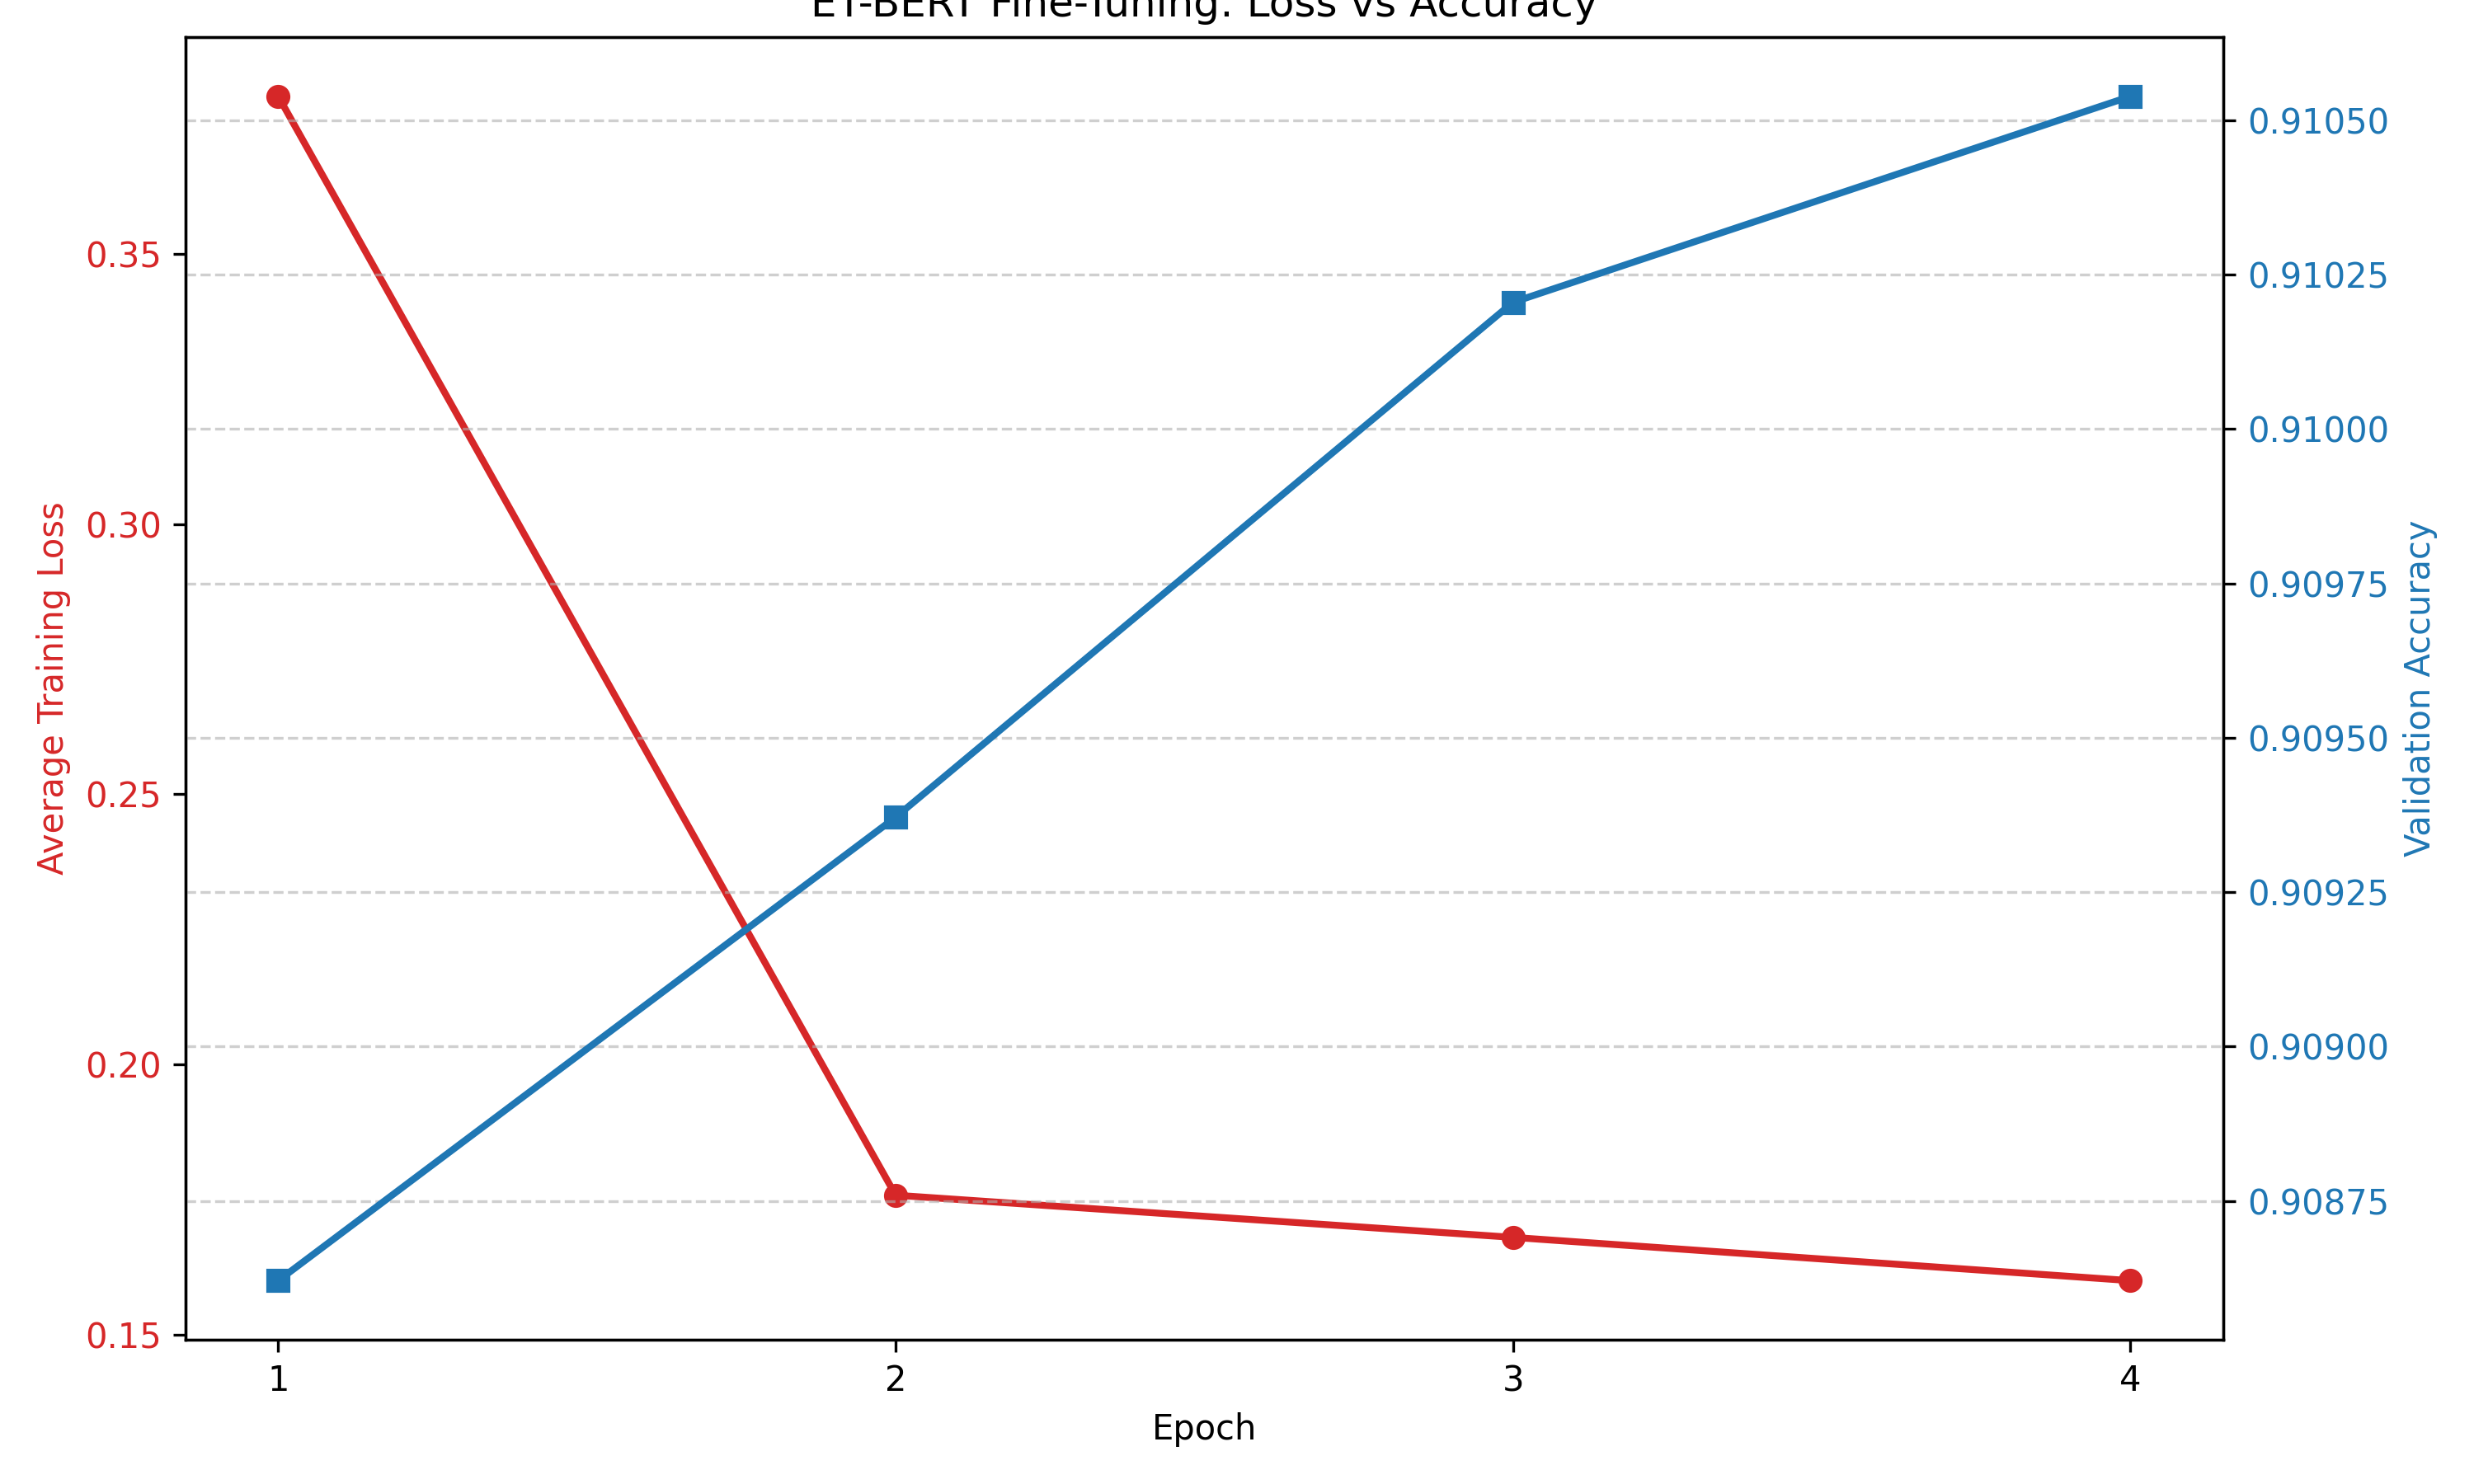

In [1]:
from IPython.display import Image, display

print("\n--- Training Tracking Graph ---")
display(Image(filename='training_history.png'))

## Phase 3: High-Speed Inference on Blind Traffic (`inference.py`)

Once the Transformer has been fine-tuned, the massive training overhead (like gradient tracking and backpropagation) is no longer needed. This phase is designed purely for execution speed. It uses the `finetuned_model.bin` to evaluate the unseen traffic in `nolabel_test_dataset.tsv`.

### 1. Evaluation Mode & Memory Locking
The script loads the newly minted model into the GPU, but it strictly applies `model.eval()` and `torch.no_grad()`.
* **Why this matters:** This locks the 86.2 million weights, completely shutting off PyTorch's gradient calculation engine. This drastically reduces VRAM consumption and massively accelerates the time it takes to process a network packet.
[Image of neural network forward pass inference]

### 2. Tokenization & Padding
The `read_dataset` function acts as the intake valve. It reads the blind hexadecimal payloads, uses `encryptd_vocab.txt` to convert the hex pairs into numerical IDs, and automatically pads or truncates every sequence to exactly 128 tokens so the Transformer can process them in uniform batches.

### 3. Logits and Output Generation
For every packet, the model outputs 24 raw mathematical scores (logits).
* The script uses `torch.argmax(logits, dim=1)` to find the index (0-23) with the absolute highest confidence score.
* It dynamically writes these predictions into a new file (`prediction.tsv`).
* *Note: This script also supports outputting the raw Softmax probabilities using the `--output_prob` flag for advanced threshold analysis.*

In [2]:
%%writefile inference.py
"""
  This script provides an exmaple to wrap UER-py for classification inference.
"""
import sys
import os
import torch
import argparse
import collections
import torch.nn as nn

uer_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
sys.path.append(uer_dir)

from uer.utils.constants import *
from uer.utils import *
from uer.utils.config import load_hyperparam
from uer.utils.seed import set_seed
from uer.model_loader import load_model
from uer.opts import infer_opts
from run_classifier import Classifier


def batch_loader(batch_size, src, seg):
    instances_num = src.size()[0]
    for i in range(instances_num // batch_size):
        src_batch = src[i * batch_size: (i + 1) * batch_size, :]
        seg_batch = seg[i * batch_size: (i + 1) * batch_size, :]
        yield src_batch, seg_batch
    if instances_num > instances_num // batch_size * batch_size:
        src_batch = src[instances_num // batch_size * batch_size:, :]
        seg_batch = seg[instances_num // batch_size * batch_size:, :]
        yield src_batch, seg_batch


def read_dataset(args, path):
    dataset, columns = [], {}
    with open(path, mode="r", encoding="utf-8") as f:
        for line_id, line in enumerate(f):
            if line_id == 0:
                line = line.strip().split("\t")
                for i, column_name in enumerate(line):
                    columns[column_name] = i
                continue
            line = line.strip().split("\t")
            if "text_b" not in columns:  # Sentence classification.
                text_a = line[columns["text_a"]]
                src = args.tokenizer.convert_tokens_to_ids([CLS_TOKEN] + args.tokenizer.tokenize(text_a))
                seg = [1] * len(src)
            else:  # Sentence pair classification.
                text_a, text_b = line[columns["text_a"]], line[columns["text_b"]]
                src_a = args.tokenizer.convert_tokens_to_ids(
                    [CLS_TOKEN] + args.tokenizer.tokenize(text_a) + [SEP_TOKEN])
                src_b = args.tokenizer.convert_tokens_to_ids(args.tokenizer.tokenize(text_b) + [SEP_TOKEN])
                src = src_a + src_b
                seg = [1] * len(src_a) + [2] * len(src_b)

            if len(src) > args.seq_length:
                src = src[: args.seq_length]
                seg = seg[: args.seq_length]
            while len(src) < args.seq_length:
                src.append(0)
                seg.append(0)
            dataset.append((src, seg))

    return dataset


def main():
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    infer_opts(parser)

    parser.add_argument("--pooling", choices=["mean", "max", "first", "last"], default="first",
                        help="Pooling type.")

    parser.add_argument("--labels_num", type=int, required=True,
                        help="Number of prediction labels.")

    parser.add_argument("--tokenizer", choices=["bert", "char", "space"], default="bert",
                        help="Specify the tokenizer."
                             "Original Google BERT uses bert tokenizer on Chinese corpus."
                             "Char tokenizer segments sentences into characters."
                             "Space tokenizer segments sentences into words according to space."
                        )

    parser.add_argument("--output_logits", action="store_true", help="Write logits to output file.")
    parser.add_argument("--output_prob", action="store_true", help="Write probabilities to output file.")

    args = parser.parse_args()

    # Load the hyperparameters from the config file.
    args = load_hyperparam(args)

    # Build tokenizer.
    args.tokenizer = str2tokenizer[args.tokenizer](args)

    # Build classification model and load parameters.
    args.soft_targets, args.soft_alpha = False, False
    model = Classifier(args)
    model = load_model(model, args.load_model_path)

    # For simplicity, we use DataParallel wrapper to use multiple GPUs.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        print("{} GPUs are available. Let's use them.".format(torch.cuda.device_count()))
        model = torch.nn.DataParallel(model)

    dataset = read_dataset(args, args.test_path)

    src = torch.LongTensor([sample[0] for sample in dataset])
    seg = torch.LongTensor([sample[1] for sample in dataset])

    batch_size = args.batch_size
    instances_num = src.size()[0]

    print("The number of prediction instances: ", instances_num)

    model.eval()

    with open(args.prediction_path, mode="w", encoding="utf-8") as f:
        f.write("label")
        if args.output_logits:
            f.write("\t" + "logits")
        if args.output_prob:
            f.write("\t" + "prob")
        f.write("\n")
        for i, (src_batch, seg_batch) in enumerate(batch_loader(batch_size, src, seg)):
            src_batch = src_batch.to(device)
            seg_batch = seg_batch.to(device)
            with torch.no_grad():
                _, logits = model(src_batch, None, seg_batch)

            pred = torch.argmax(logits, dim=1)
            pred = pred.cpu().numpy().tolist()
            prob = nn.Softmax(dim=1)(logits)
            logits = logits.cpu().numpy().tolist()
            prob = prob.cpu().numpy().tolist()

            for j in range(len(pred)):
                f.write(str(pred[j]))
                if args.output_logits:
                    f.write("\t" + " ".join([str(v) for v in logits[j]]))
                if args.output_prob:
                    f.write("\t" + " ".join([str(v) for v in prob[j]]))
                f.write("\n")


if __name__ == "__main__":
    main()

Writing inference.py


In [2]:
# Execute Phase 3: High-Speed Blind Inference
!python inference.py --load_model_path Model/finetuned_model.bin --vocab_path Model/encryptd_vocab.txt --config_path Model/base_config.json --test_path nolabel_test_dataset.tsv --prediction_path Datasets/prediction.tsv --labels_num 24 --seq_length 128 --batch_size 16

The number of prediction instances:  11993


In [3]:
%%writefile translate.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The exact 24 classes sorted alphabetically
classes = [
    "BitTorrent", "Cridex Malware", "FTP", "Facetime", "Geodo Malware",
    "Gmail", "Htbot Malware", "Miuref Malware", "MySQL", "Neris Malware",
    "Nsis-ay Malware", "Outlook", "SMB-1", "SMB-2", "Shifu Malware",
    "Skype", "Tinba Malware", "Virut Malware", "Weibo-1", "Weibo-2",
    "Weibo-3", "Weibo-4", "WorldOfWarcraft", "Zeus Malware"
]

print("Reading the Answer Key (test_dataset.tsv)...")
with open("Datasets/test_dataset.tsv", "r") as f:
    # Skip the first line (header)
    true_lines = f.readlines()[1:]

print("Reading the AI's Guesses (prediction.tsv)...")
with open("Datasets/prediction.tsv", "r") as f:
    # Skip the first line (header)
    pred_lines = f.readlines()[1:]

results = []
correct_count = 0

for index, (true_line, pred_line) in enumerate(zip(true_lines, pred_lines)):
    # The true dataset has the label and the hex text separated by a tab
    true_label_id = int(true_line.split('\t')[0])

    # The prediction file just has the number
    pred_label_id = int(pred_line.strip())

    # Check if the AI got it right
    is_correct = (true_label_id == pred_label_id)
    if is_correct:
        correct_count += 1

    results.append({
        "Packet_ID": index + 1,
        "True_Family": classes[true_label_id],
        "Predicted_Family": classes[pred_label_id],
        "Is_Correct": "✅ YES" if is_correct else "❌ NO"
    })

# Save the graded test to a new CSV
df = pd.DataFrame(results)
output_file = "Metrics/graded_predictions.csv"
df.to_csv(output_file, index=False)

# Calculate final grade
accuracy = (correct_count / len(pred_lines)) * 100

print(f"\n--- FINAL GRADE ---")
print(f"Total Packets Checked: {len(pred_lines)}")
print(f"Correct Guesses: {correct_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Saved full report to: {output_file}")

# ==========================================
# NEW: GENERATE THE CLASS-WISE BAR CHART
# ==========================================
print("\nGenerating class-wise accuracy graph...")

# Group by the true class to get total packets and correctly predicted packets
class_stats = df.groupby('True_Family').apply(
    lambda x: pd.Series({
        'Total': len(x),
        'Correct': (x['Is_Correct'] == '✅ YES').sum()
    })
).reset_index()

# Enforce the original alphabetical order on the x-axis
class_stats['True_Family'] = pd.Categorical(class_stats['True_Family'], categories=classes, ordered=True)
class_stats = class_stats.sort_values('True_Family')

# Initialize the matplotlib figure
plt.figure(figsize=(18, 8))
sns.set_theme(style="whitegrid")

# Plot 1: The Total Packets (Background bar - Light Gray)
sns.barplot(x="True_Family", y="Total", data=class_stats, color="#d3d3d3", label="Total Ground Truth Packets")

# Plot 2: The Correctly Predicted Packets (Foreground bar - Dark Blue/Green)
sns.barplot(x="True_Family", y="Correct", data=class_stats, color="#2ca02c", label="Correctly Predicted")

# Add informative labels and title
plt.title('ET-BERT Prediction Accuracy by Traffic Class', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Traffic Family', fontsize=14, labelpad=15)
plt.ylabel('Number of Packets', fontsize=14, labelpad=15)

# Rotate the x labels 45 degrees so all 24 names are legible without overlapping
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

# Add a legend at the top right
plt.legend(ncol=1, loc="upper right", frameon=True, fontsize=12)

# Adjust layout and save
plt.tight_layout()
graph_filename = 'Metrics/class_accuracy_bar_chart.png'
plt.savefig(graph_filename, dpi=300)
plt.show()

print(f"--> Success: Graph saved as '{graph_filename}'")

Writing translate.py


In [4]:
!python translate.py

Reading the Answer Key (test_dataset.tsv)...
Reading the AI's Guesses (prediction.tsv)...

--- FINAL GRADE ---
Total Packets Checked: 11993
Correct Guesses: 10924
Accuracy: 91.09%
Saved full report to: Metrics/graded_predictions.csv

Generating class-wise accuracy graph...
Figure(1800x800)
--> Success: Graph saved as 'Metrics/class_accuracy_bar_chart.png'


In [5]:
%%writefile plot_confusion.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# The exact 24 classes sorted alphabetically
classes = [
    "BitTorrent", "Cridex Malware", "FTP", "Facetime", "Geodo Malware",
    "Gmail", "Htbot Malware", "Miuref Malware", "MySQL", "Neris Malware",
    "Nsis-ay Malware", "Outlook", "SMB-1", "SMB-2", "Shifu Malware",
    "Skype", "Tinba Malware", "Virut Malware", "Weibo-1", "Weibo-2",
    "Weibo-3", "Weibo-4", "WorldOfWarcraft", "Zeus Malware"
]

print("Loading Ground Truth and Predictions...")

with open("Datasets/test_dataset.tsv", "r") as f:
    true_lines = f.readlines()[1:]

with open("Datasets/prediction.tsv", "r") as f:
    pred_lines = f.readlines()[1:]

y_true = []
y_pred = []

for true_line, pred_line in zip(true_lines, pred_lines):
    y_true.append(int(true_line.split('\t')[0]))
    y_pred.append(int(pred_line.strip()))

# Generate the raw mathematical matrix
cm = confusion_matrix(y_true, y_pred)

print("Drawing the Heatmap...")
# Set up the matplotlib figure (made it very large so all 24 classes fit perfectly)
plt.figure(figsize=(22, 18))
sns.set_theme(style="white")

# Draw the heatmap using Seaborn
# annot=True puts the actual numbers inside the boxes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            linewidths=0.5, linecolor='gray', square=True,
            cbar_kws={"shrink": .75})

plt.title('ET-BERT Traffic Classification: Confusion Matrix', fontsize=26, pad=20, fontweight='bold')
plt.ylabel('True Traffic Family (What it actually is)', fontsize=18, labelpad=15)
plt.xlabel('Predicted Traffic Family (What the AI guessed)', fontsize=18, labelpad=15)

# Rotate the labels so they don't overlap
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
graph_filename = 'Metrics/confusion_matrix_heatmap.png'
plt.savefig(graph_filename, dpi=300)
print(f"--> Success: Heatmap saved as '{graph_filename}'")

Writing plot_confusion.py


Loading Ground Truth and Predictions...
Drawing the Heatmap...
--> Success: Heatmap saved as 'Metrics/confusion_matrix_heatmap.png'


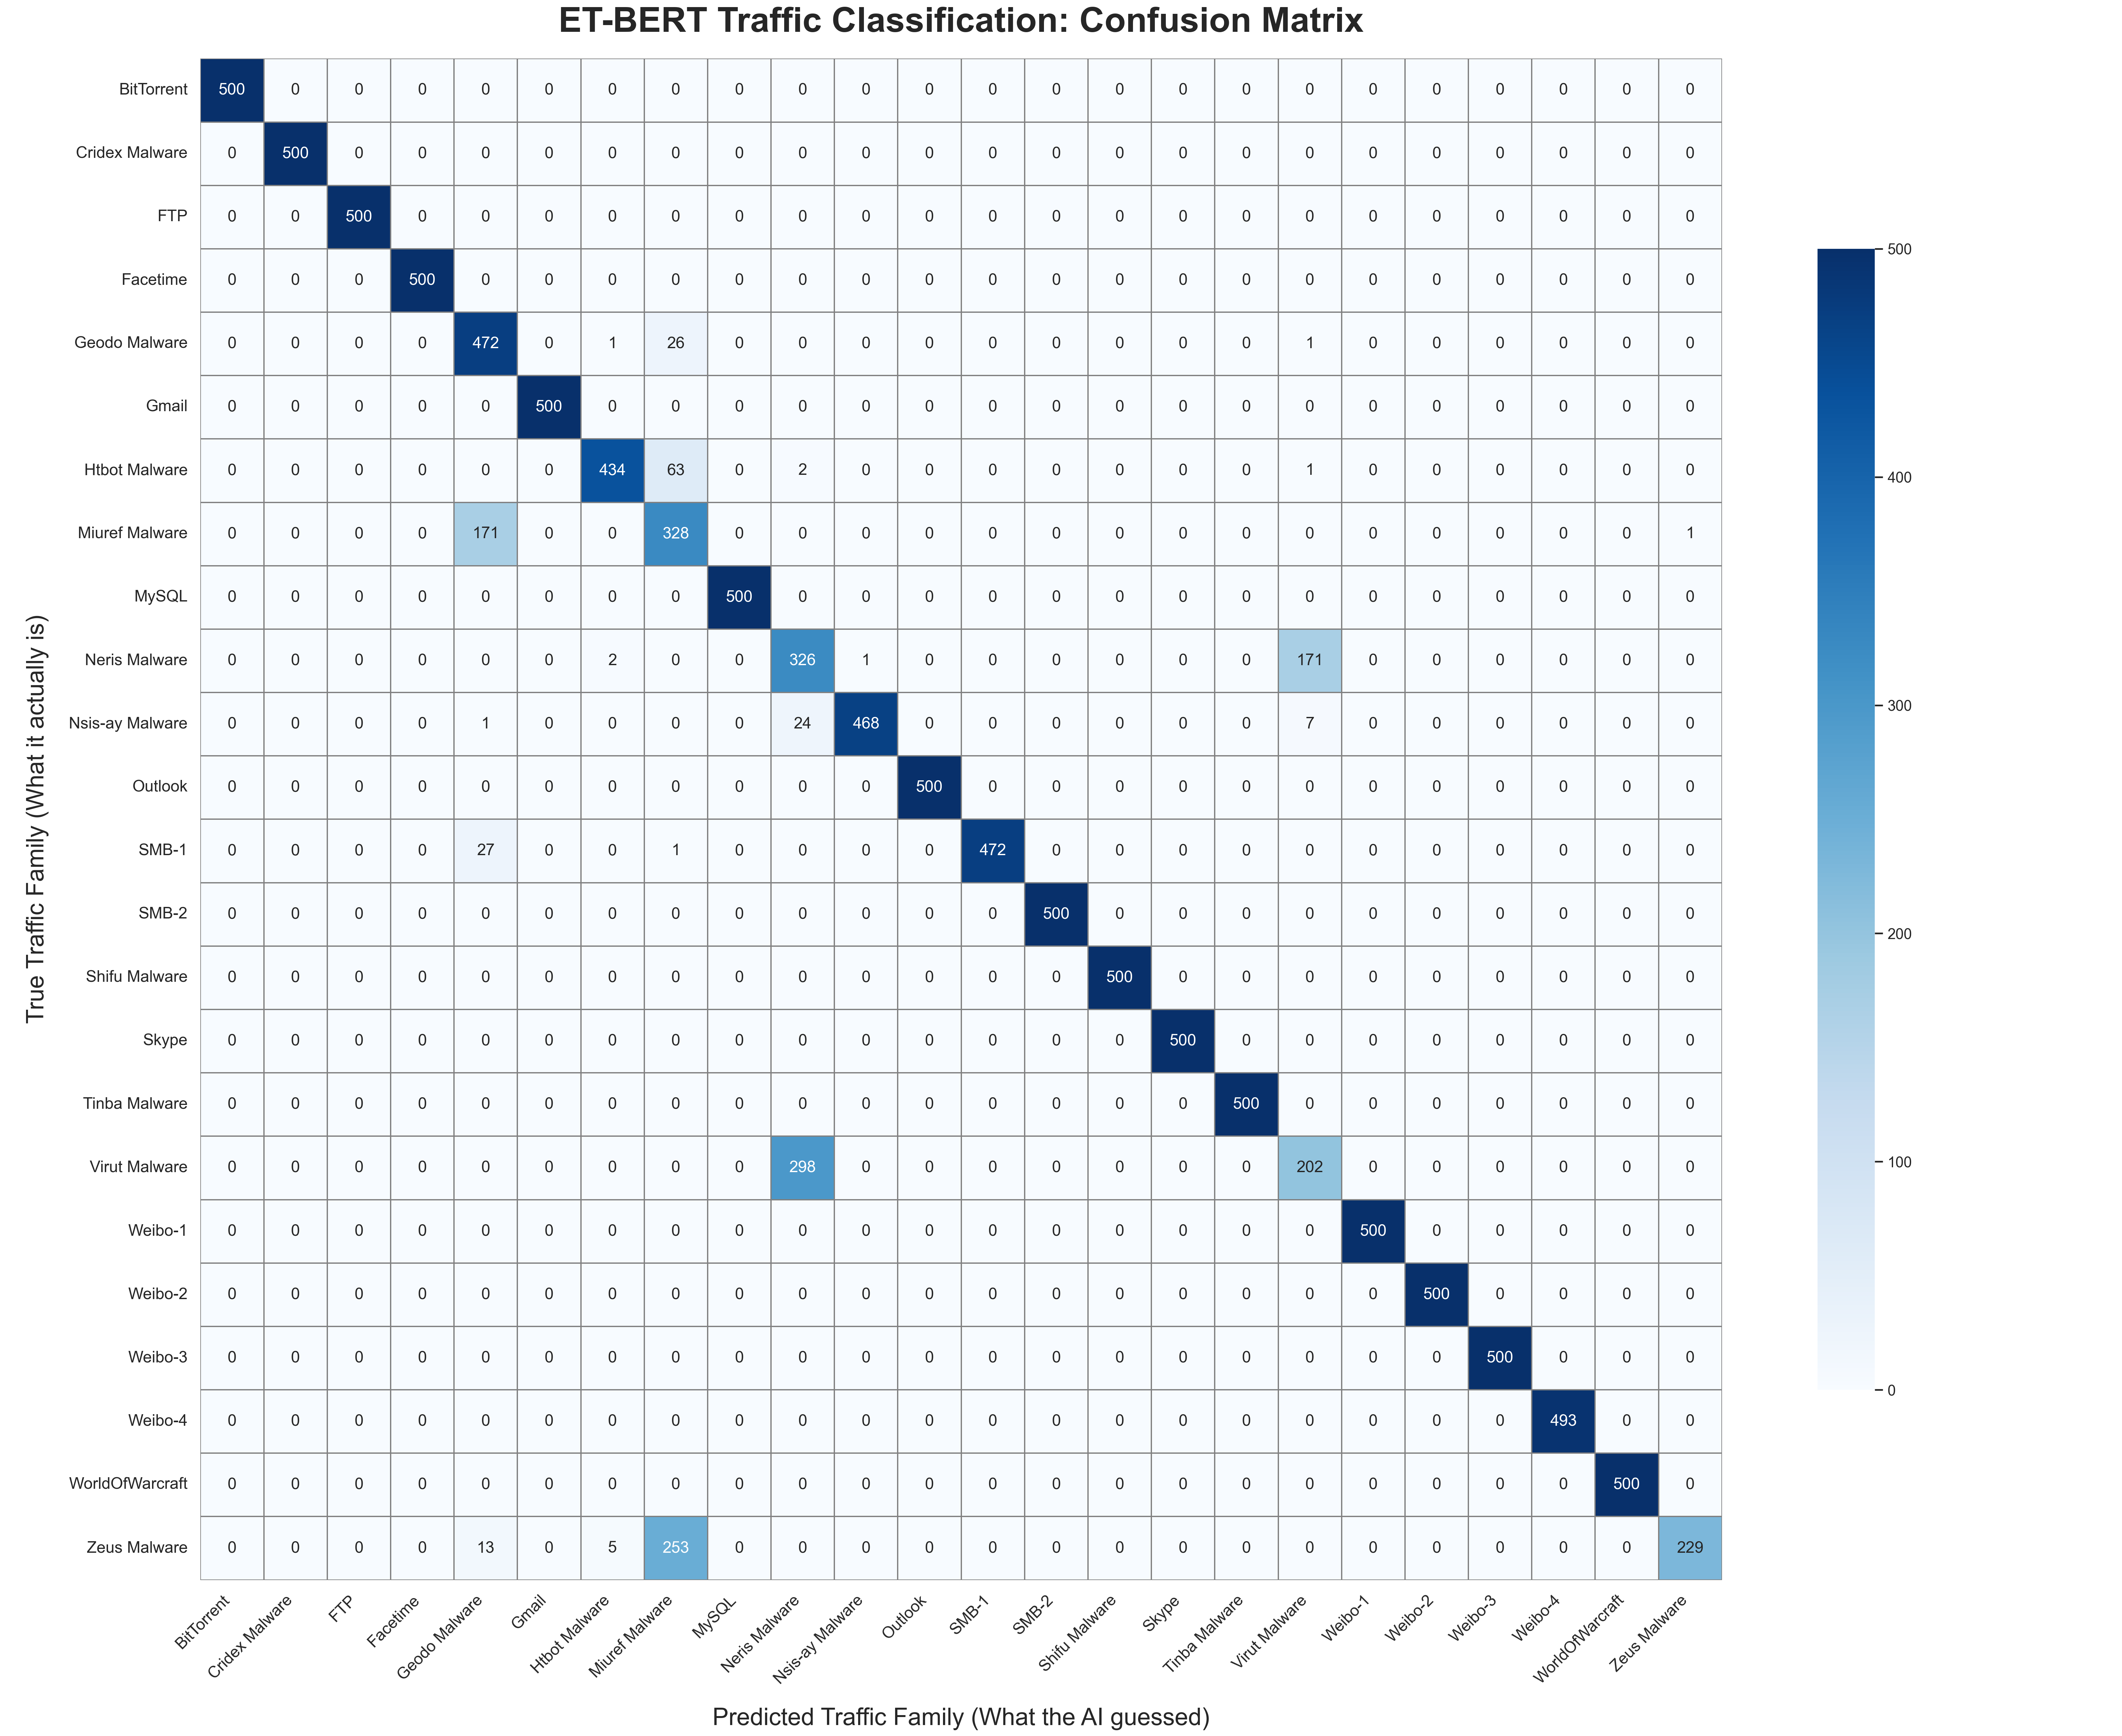

In [6]:
!python plot_confusion.py

from IPython.display import Image, display
display(Image(filename='Metrics/confusion_matrix_heatmap.png'))

In [10]:
%%writefile binary_evaluation.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# The exact 24 classes sorted alphabetically
classes = [
    "BitTorrent", "Cridex Malware", "FTP", "Facetime", "Geodo Malware",
    "Gmail", "Htbot Malware", "Miuref Malware", "MySQL", "Neris Malware",
    "Nsis-ay Malware", "Outlook", "SMB-1", "SMB-2", "Shifu Malware",
    "Skype", "Tinba Malware", "Virut Malware", "Weibo-1", "Weibo-2",
    "Weibo-3", "Weibo-4", "WorldOfWarcraft", "Zeus Malware"
]

print("Loading Ground Truth and Predictions...")
with open("Datasets/test_dataset.tsv", "r") as f:
    true_lines = f.readlines()[1:]

with open("Datasets/prediction.tsv", "r") as f:
    pred_lines = f.readlines()[1:]

y_true_binary = []
y_pred_binary = []

# Grouping Logic: If the word "Malware" is in the class name, it goes to the Malware bucket.
for true_line, pred_line in zip(true_lines, pred_lines):
    true_id = int(true_line.split('\t')[0])
    pred_id = int(pred_line.strip())

    true_category = "Malware" if "Malware" in classes[true_id] else "Benign"
    pred_category = "Malware" if "Malware" in classes[pred_id] else "Benign"

    y_true_binary.append(true_category)
    y_pred_binary.append(pred_category)

# Calculate overall binary accuracy
correct_count = sum(1 for t, p in zip(y_true_binary, y_pred_binary) if t == p)
accuracy = (correct_count / len(y_true_binary)) * 100

print(f"\n--- FIREWALL SECURITY POSTURE (Benign vs Malware) ---")
print(f"Total Packets Evaluated: {len(y_true_binary)}")
print(f"Successfully Handled: {correct_count}")
print(f"New Real-World Accuracy: {accuracy:.2f}%\n")

print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_true_binary, y_pred_binary, labels=["Benign", "Malware"]))

# Generate the 2x2 Confusion Matrix
print("\nDrawing the Binary Heatmap...")
labels = ["Benign", "Malware"]
cm = confusion_matrix(y_true_binary, y_pred_binary, labels=labels)

plt.figure(figsize=(8, 6))
sns.set_theme(style="white")

# Using a green colormap to signify firewall success
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels,
            linewidths=1, linecolor='gray', square=True, annot_kws={"size": 16})

plt.title('ET-BERT Firewall: Benign vs. Malware', fontsize=18, pad=15, fontweight='bold')
plt.ylabel('True Traffic Type (Reality)', fontsize=14, labelpad=10)
plt.xlabel('Predicted Traffic Type (AI Decision)', fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13, rotation=0)

plt.tight_layout()
graph_filename = 'Metrics/binary_confusion_matrix.png'
plt.savefig(graph_filename, dpi=300)
print(f"--> Success: Heatmap saved as '{graph_filename}'")

Overwriting binary_evaluation.py


Loading Ground Truth and Predictions...

--- FIREWALL SECURITY POSTURE (Benign vs Malware) ---
Total Packets Evaluated: 11993
Successfully Handled: 11965
New Real-World Accuracy: 99.77%

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      6993
     Malware       0.99      1.00      1.00      5000

    accuracy                           1.00     11993
   macro avg       1.00      1.00      1.00     11993
weighted avg       1.00      1.00      1.00     11993


Drawing the Binary Heatmap...
--> Success: Heatmap saved as 'Metrics/binary_confusion_matrix.png'


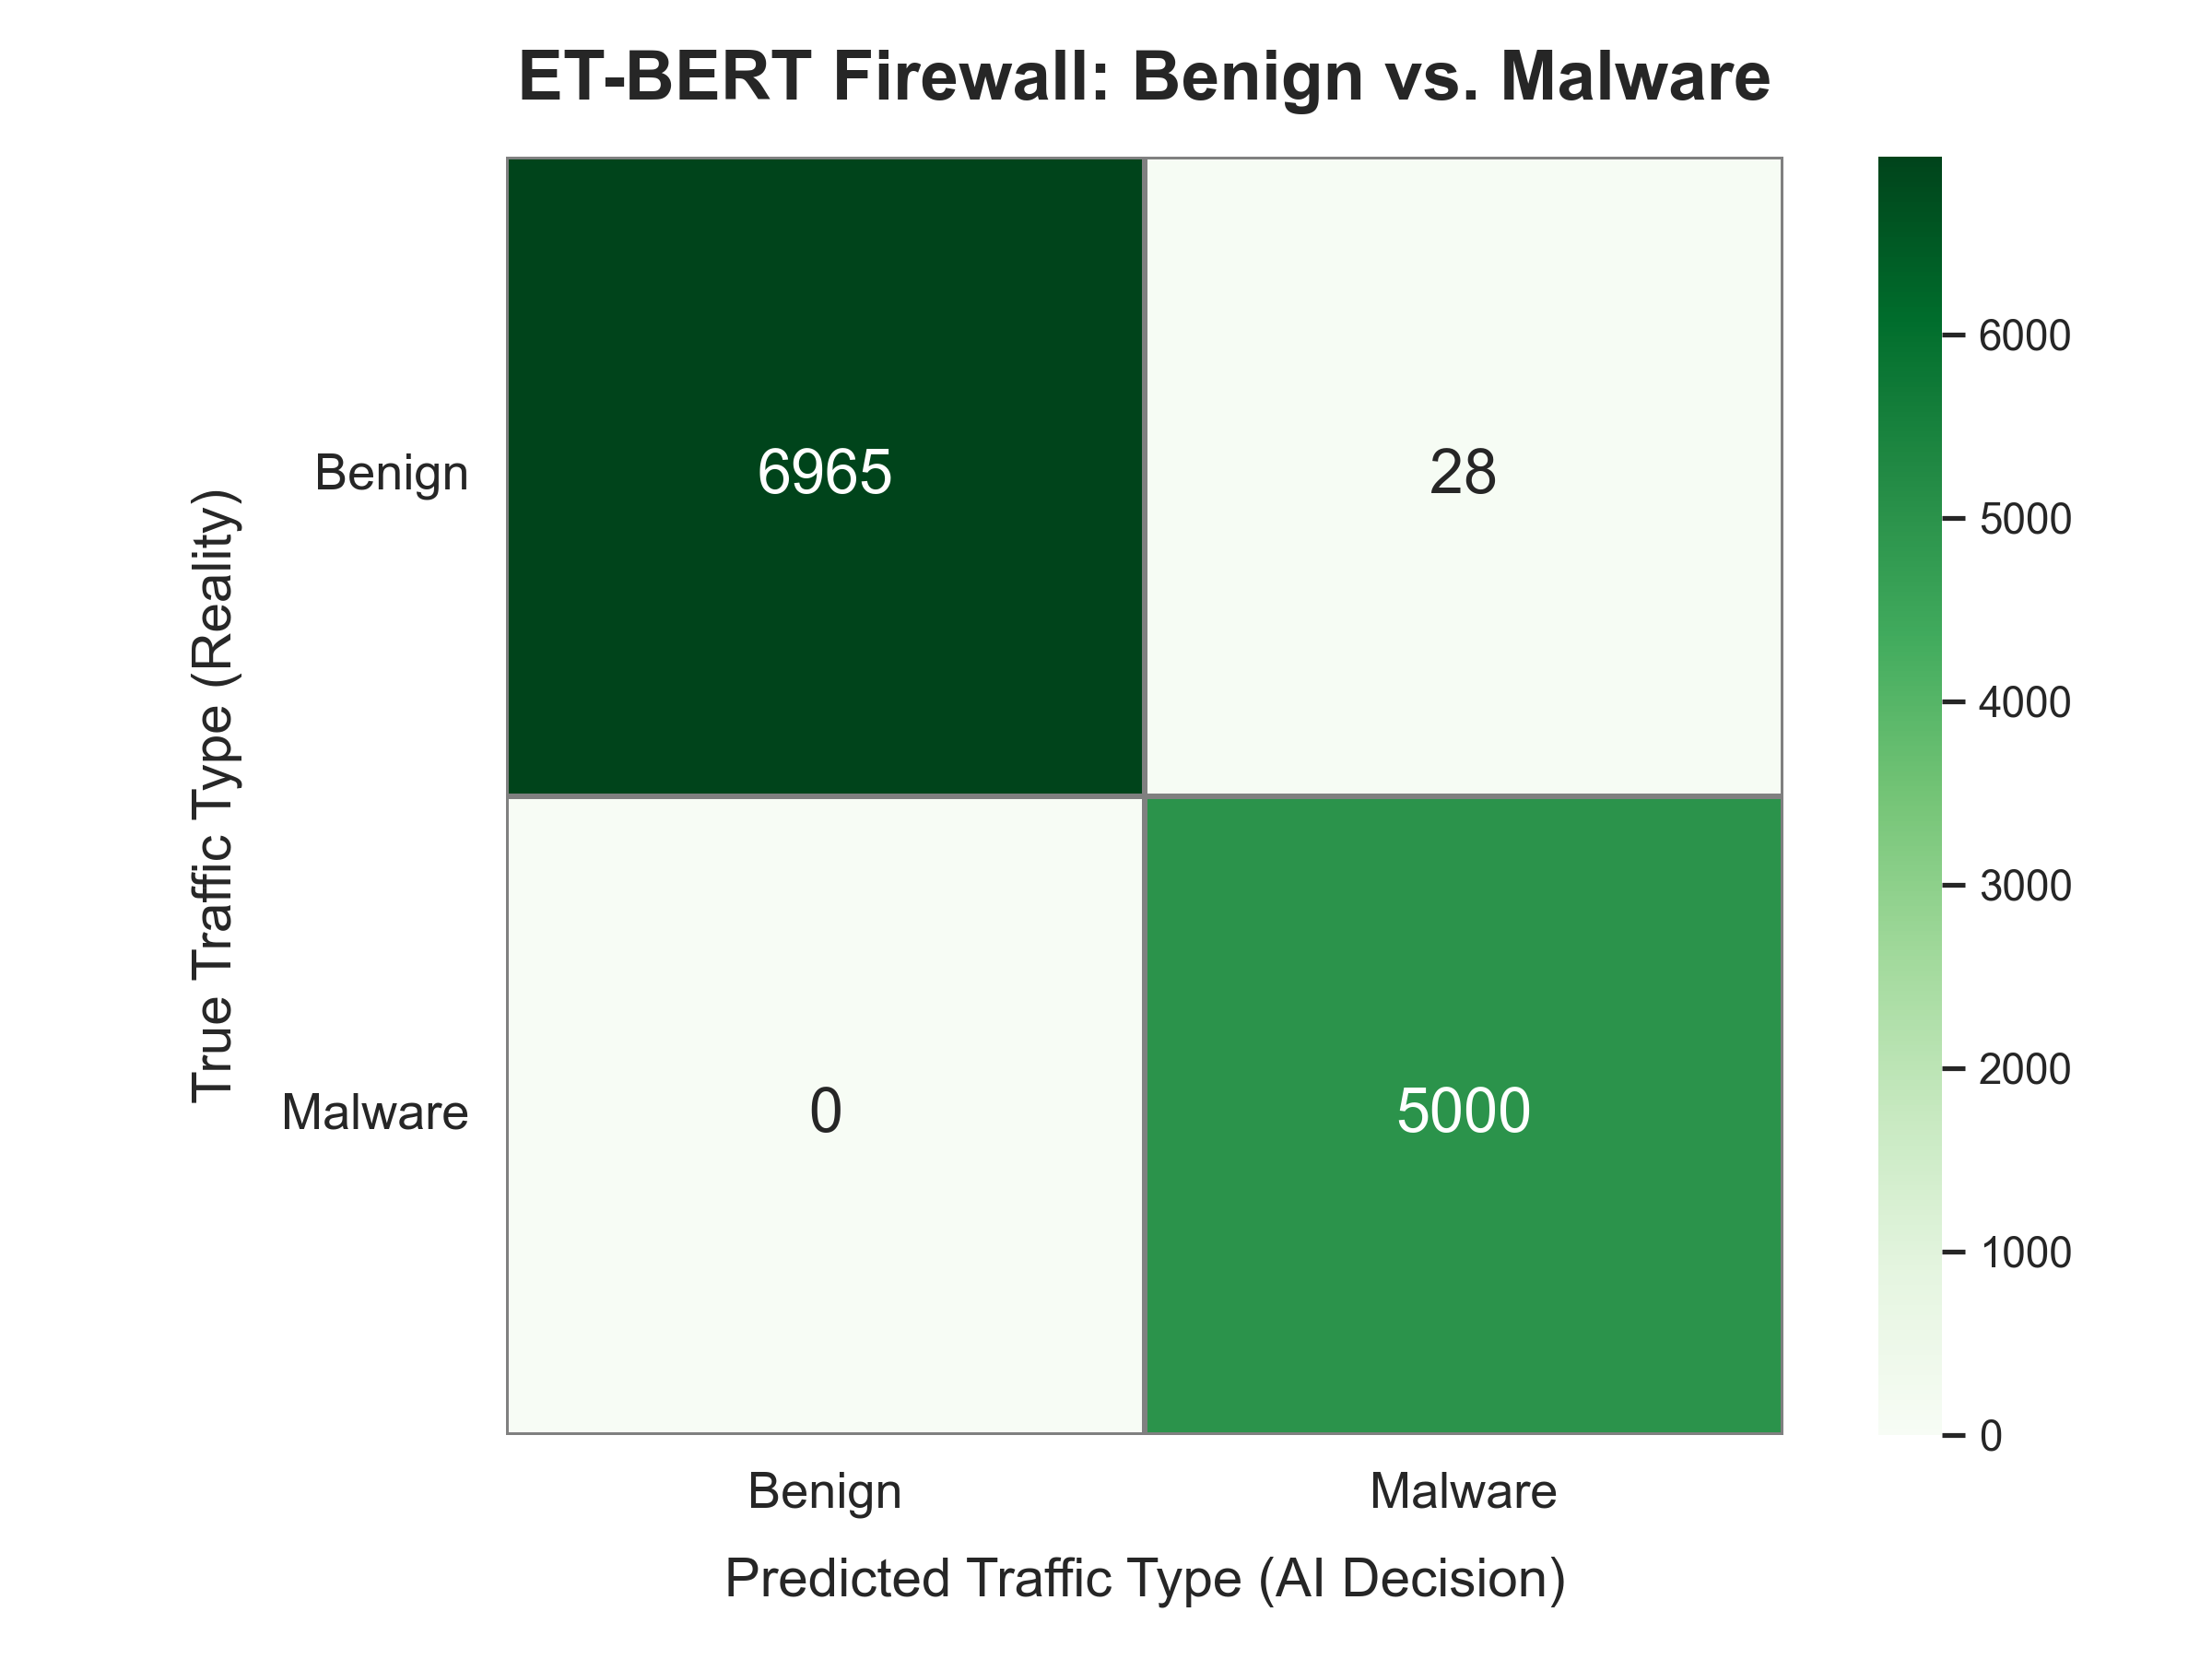

In [11]:
!python binary_evaluation.py

from IPython.display import Image, display
display(Image(filename='Metrics/binary_confusion_matrix.png'))